In [3]:
import pickle
from string import punctuation

import pandas as pd
from sklearn.model_selection import train_test_split

In [4]:
import numpy as np
import json
import dask.bag as db

In [2]:
# Load the data
import logging
logger = logging.getLogger("spacy")
logger.setLevel(logging.ERROR)

import dask.bag as db
import json

docs = db.read_text('../Data/arxiv-metadata-oai-snapshot.json').map(json.loads)

In [ ]:
# Trimming the data
get_latest_version = lambda x: x['versions'][-1]['created']


# get only necessary fields of the metadata file
trim = lambda x: {'id': x['id'],
                  'authors': x['authors'],
                  'title': x['title'],
                  'versions': x['versions'],
                  'category':x['categories'].split(' '),
                  'abstract':x['abstract'],}

# filter for papers published on or after 2019-01-01
columns = ['id','category','abstract','versions']
docs_df = docs.map(trim).compute()

# convert to pandas
docs_df = pd.DataFrame(docs_df)

In [ ]:
#save trimmed dataset for later use so we can skip the dataset trimming later:
docs_df.to_csv("../Data/trimmed_arxiv_docs2.csv", index=False)

In [3]:
# Read docs from the file
docs_df = pd.read_csv('../Data/trimmed_arxiv_docs2.csv')

/Users/miamijovic/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
# Listing categories
categories = list(docs_df['category'].unique())

In [3]:
# Split categories
def splitCategory(cat):
    tmp = cat.replace('[','').replace(']','')
    c = tmp.split(', ')
    c = [w.replace("'","") for w in c]
    return c

In [4]:
# Find main category
def findMainCat(categories):
    new_cat = list(dict.fromkeys([cat.split(".")[0] for cat in categories]))
    return new_cat


Cleaning the data

In [6]:
df = pd.read_csv("../Data/trimmed_arxiv_docs2.csv")

In [7]:
# Adding abstract word count
df['abstract_word_count'] = docs_df['abstract'].apply(lambda x: len(x.strip().split())) 

In [8]:
df['abstract'].describe(include='all')

count                                1967621
unique                               1965958
top         This paper has been withdrawn.\n
freq                                      91
Name: abstract, dtype: object

In [9]:
# Getting rid of duplicates
df.drop_duplicates(['abstract',], inplace=True)
df['abstract'].describe(include='all')

count                                               1965958
unique                                              1965958
top         A fully differential calculation in perturba...
freq                                                      1
Name: abstract, dtype: object

NLP data processing

In [10]:
# Add the categories
df['list_categories'] = df.category.apply(splitCategory)
df['main_categories'] = df.list_categories.apply(findMainCat)

In [11]:
# Create CS and Random dataframes
bool_series = ["cs" in cat for cat in df.main_categories]
df_cs = df[bool_series]

In [12]:
# Non-CS df
bool_series = ["cs" not in cat for cat in df.main_categories]
df_random = df[bool_series]

In [13]:
# Reduce the size of the data
df_cs = df_cs.sample(100000, random_state=42)
df_random = df_random.sample(100000, random_state=42)

In [5]:
def get_year(version):
    return version.split(': ')[2].split(' ')[3]

In [15]:
df_cs['year'] = df_cs.versions.apply(get_year)
df_random['year'] = df_random.versions.apply(get_year)

In [16]:
print(sorted(set(df_cs.year)))

['1991', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021']


In [6]:
#Define stopwords (scientific stopwords)
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
stopwords = STOP_WORDS

In [21]:
#Define the cleaner - remove punctuation and stopwords
def cleanPunct(text):
    return [w for w in text if w not in punctuation]

In [38]:
# make everything lowercase
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
def low(instance):
    tokens = word_tokenize(instance)
    return [w.lower() for w in tokens if w not in ["(", ")"]]
# Removing stopwords and punctuation
def clean(text):
    return [w for w in text if w not in punctuation and w not in stopwords and w.isalpha() and len(w)>1]
def low2(instance):
    tokens = word_tokenize(instance)
    return [w.lower() for w in tokens if w not in punctuation and w not in stopwords and w.isalpha() and len(w)>1]

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/miamijovic/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [39]:
# Create column with lowercase text
df_cs['cleaned'] = df_cs.abstract.apply(low2)
df_random['cleaned'] = df_random.abstract.apply(low2)


In [40]:
def removeStopwords(text):
    return [w for w in text if w not in stopwords]

In [41]:
#apply cleaning punctiation on unigrams
df_cs['cleaned'] = df_cs.cleaned.apply(removeStopwords)
df_random['cleaned'] = df_random.cleaned.apply(removeStopwords)

In [42]:
df_cs

,id,authors,title,versions,category,abstract,abstract_word_count,list_categories,main_categories,year,cleaned,bigrams,trigrams
948505,1802.08965,"Hamid G. Bafghi, Amin Gohari, Mahtab Mirmohsen...",Diffusion Based Molecular Communication with L...,"[{'version': 'v1', 'created': 'Sun, 25 Feb 201...","['cs.IT', 'math.IT']",This paper studies the impact of a transmitt...,160,"[cs.IT, math.IT]","[cs, math]",2018,"[paper, studies, impact, transmitter, molecule...","[(paper, studies), (studies, impact), (impact,...","[(paper, studies, impact), (studies, impact, t..."
1497027,2107.03015,Juan Jose Garau-Luis and Edward Crawley and Br...,Evaluating the progress of Deep Reinforcement ...,"[{'version': 'v1', 'created': 'Wed, 7 Jul 2021...","['cs.LG', 'cs.AI']",Deep Reinforcement Learning (DRL) is conside...,128,"[cs.LG, cs.AI]",[cs],2021,"[deep, reinforcement, learning, drl, considere...","[(deep, reinforcement), (reinforcement, learni...","[(deep, reinforcement, learning), (reinforceme..."
1040347,1810.0916,"Peter Snyder, Antoine Vastel, Benjamin Livshits",Who Filters the Filters: Understanding the Gro...,"[{'version': 'v1', 'created': 'Mon, 22 Oct 201...",['cs.CR'],Ad and tracking blocking extensions are popu...,275,[cs.CR],[cs],2018,"[ad, tracking, blocking, extensions, popular, ...","[(ad, tracking), (tracking, blocking), (blocki...","[(ad, tracking, blocking), (tracking, blocking..."
1189193,1910.05274,"Jan H\k{a}z{\l}a, Yan Jin, Elchanan Mossel, Go...",A Geometric Model of Opinion Polarization,"[{'version': 'v1', 'created': 'Fri, 11 Oct 201...","['cs.SI', 'econ.TH']","We introduce a simple, geometric model of op...",103,"[cs.SI, econ.TH]","[cs, econ]",2019,"[introduce, simple, geometric, model, opinion,...","[(introduce, simple), (simple, geometric), (ge...","[(introduce, simple, geometric), (simple, geom..."
1336457,2008.08735,"Shuangjun Liu, Xiaofei Huang, Nihang Fu, Cheng...",Simultaneously-Collected Multimodal Lying Pose...,"[{'version': 'v1', 'created': 'Thu, 20 Aug 202...",['cs.CV'],Computer vision (CV) has achieved great succ...,198,[cs.CV],[cs],2020,"[computer, vision, cv, achieved, great, succes...","[(computer, vision), (vision, cv), (cv, achiev...","[(computer, vision, cv), (vision, cv, achieved..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1344213,2009.0271,Niloufar Ahmadypour and Amin Gohari,Multi-Way Number Partitioning: an Information-...,"[{'version': 'v1', 'created': 'Sun, 6 Sep 2020...","['cs.DS', 'cs.IT', 'math.CO', 'math.IT']",The number partitioning problem is the probl...,82,"[cs.DS, cs.IT, math.CO, math.IT]","[cs, math]",2020,"[number, partitioning, problem, problem, parti...","[(number, partitioning), (partitioning, proble...","[(number, partitioning, problem), (partitionin..."
1376344,2011.03596,"Iulia-Cristina Stanica, Florica Moldoveanu, Gi...",Flexible Virtual Reality System for Neurorehab...,"[{'version': 'v1', 'created': 'Fri, 6 Nov 2020...",['cs.GR'],"As life expectancy is mostly increasing, the...",210,[cs.GR],[cs],2020,"[life, expectancy, increasing, incidence, neur...","[(life, expectancy), (expectancy, increasing),...","[(life, expectancy, increasing), (expectancy, ..."
809176,1701.03768,Robert Ferens and Marek Szyku{\l}a,Complexity of regular bifix-free languages,"[{'version': 'v1', 'created': 'Fri, 13 Jan 201...",['cs.FL'],We study descriptive complexity properties o...,212,[cs.FL],[cs],2017,"[study, descriptive, complexity, properties, c...","[(study, descriptive), (descriptive, complexit...","[(study, descriptive, complexity), (descriptiv..."
1488093,2106.10329,"Ryan H. Vogt, N. Anders Petersson",Binary Optimal Control Of Single-Flux-Quantum ...,"[{'version': 'v1', 'created': 'Fri, 18 Jun 202...","['quant-ph', 'cs.NA', 'math.DS', 'math.NA', 'm...","We introduce a binary, relaxed gradient, tru...",147,"[quant-ph, cs.NA, math.DS, math.NA, math.OC]","[quant-ph, cs, math]",2021,"[introduce, binary, relaxed, gradient, method,...","[(introduce, binary), (binary, relaxed), (rela...","[(i

In [43]:
# Make ngrams
from nltk.util import ngrams

def bigrams(arr):
    return list(ngrams(arr, 2))

def trigrams(arr):
    return list(ngrams(arr,3))

In [44]:
# Creating ngrams
df_cs['bigrams'] = df_cs.cleaned.apply(bigrams)
df_random['bigrams'] = df_random.cleaned.apply(bigrams)
df_cs['trigrams'] = df_cs.cleaned.apply(trigrams)
df_random['trigrams'] = df_random.cleaned.apply(trigrams)


In [45]:
def hyphenate(words, n):
    if(n==2):
        return [w[0]+'-'+w[1] for w in words]
    if(n==3):
        return [w[0]+'-'+w[1]+'-'+w[2] for w in words]

Dictionaties and most frequent term analysis

In [46]:
# Create dict func
def createDict(data):
    vocab = {}
    for instance in data:
        d = Counter(instance)
        for w in d.keys():
            if w in vocab:
                vocab[w] += d[w]
            else:
                vocab[w] = d[w]
    return dict(sorted(vocab.items(), key=lambda item: item[1], reverse=True))

In [47]:
from collections import Counter
uni_cs = createDict(df_cs['cleaned'])
bi_cs = createDict(df_cs['bigrams'])
tri_cs = createDict(df_cs['trigrams'])

uni_rand = createDict(df_random['cleaned'])
bi_rand = createDict(df_random['bigrams'])
tri_rand = createDict(df_random['trigrams'])

In [48]:
print(len(tri_cs))

7411967


In [ ]:
print(list(bi_cs.items())[:1000])

In [51]:
# Trim ngrams 
def trim(d, num):
    return dict((k, v) for k, v in d.items() if v>=num)

In [95]:
trim_value = 120
unigram_cs = trim(uni_cs, trim_value)
unigram_rand = trim(uni_rand, trim_value)
bigram_cs = trim(bi_cs, trim_value)
bigram_rand = trim(bi_rand, trim_value)
trigram_cs = trim(tri_cs, trim_value)
trigram_rand = trim(tri_rand, trim_value)

In [54]:
print(len(trigram_rand))

93


In [55]:
# Filter out dataframe, leave only ngrams from the list + hyphenate
def filterOutUniCs(words):
    return [w for w in words if w in unigram_cs]
def filterOutBiCs(words):
    return [w[0]+'-'+w[1] for w in words if w in bigram_cs]
def filterOutTriCs(words):
    return [w[0]+'-'+w[1]+'-'+w[2] for w in words if w in trigram_cs]
def filterOutUniRand(words):
    return [w for w in words if w in unigram_rand]
def filterOutBiRand(words):
    return [w[0]+'-'+w[1] for w in words if w in bigram_rand]
def filterOutTriRand(words):
    return [w[0]+'-'+w[1]+'-'+w[2] for w in words if w in trigram_rand]

In [56]:
df_cs.cleaned = df_cs.cleaned.apply(filterOutUniCs)
df_cs.bigrams = df_cs.bigrams.apply(filterOutBiCs)
df_cs.trigrams = df_cs.trigrams.apply(filterOutTriCs)

df_random.cleaned = df_random.cleaned.apply(filterOutUniRand)
df_random.bigrams = df_random.bigrams.apply(filterOutBiRand)
df_random.trigrams = df_random.trigrams.apply(filterOutTriRand)

In [96]:
bigram_cs = hyphenate(bigram_cs, 2)
bigram_rand = hyphenate(bigram_rand, 2)
trigram_cs = hyphenate(trigram_cs, 3)
trigram_rand = hyphenate(tri_rand, 3)

Feature Selection on CS vs Random

In [7]:
#CHI-Square stastic where:
# a - number of times t and c co-occur 11
# b - number of times t occurs w/o c 10
# c - number of times c occurs w/o t 01
# d - number of times neither c nor t occur 00
def chi_square(n,a,b,c,d):
    return n*((a*d-c*b)**2)/((a+c)*(b+d)*(a+b)*(c+d))

In [8]:
def selectKbest(features, k):
    features = {a: v for a, v in sorted(features.items(), key=lambda item: item[1], reverse=True)}
    features = {a: features[a] for a in list(features)[:k]}
    return features

In [9]:
def findOccurrences(term, C, notC):
    a = 0
    b = 0
    c = 0
    d = 0
    for instance in C['filteredAbstracts'].keys():
        if term in C['filteredAbstracts'][instance]:
            a += 1
        else:
            c += 1
    for instance in notC['filteredAbstracts'].keys():
        if term in notC['filteredAbstracts'][instance]:
            b += 1
        else:
            d += 1
    return a,b,c,d

In [10]:
from collections import Counter
def findAllTerms(cs_dict, random_dict):
    allTerms = []
    for instance in cs_dict['filteredAbstracts'].keys():
        allTerms = list(set(allTerms + cs_dict['filteredAbstracts'][instance]))
    for instance in random_dict['filteredAbstracts'].keys():
        allTerms = list(set(allTerms + random_dict['filteredAbstracts'][instance]))
    return allTerms

In [12]:
def findChiValues(cs_dict, random_dict):
    allTerms = findAllTerms(cs_dict, random_dict)
    print(len(allTerms))
    chi_values = {}
    #n is supposed to be 2x100000
    n = len(cs_dict['cleaned'])+len(random_dict['cleaned'])
    for term in allTerms:
        a,b,c,d = findOccurrences(term, cs_dict, random_dict)
        chi_values[term] = chi_square(n, a, b, c, d)
    return chi_values

In [13]:
# a - number of times t and c co-occur 11 (term occurs in cs)
# b - number of times t occurs w/o c 10 (term occurs in random)
# c - number of times c occurs w/o t 01 (cs which dont contain term)
# d - number of times neither c nor t occur 00 (random which dont contain term)
def findChiValuesQuicker(cs_dict, random_dict, n):
    occurance_dict = {}
    chi_values = {}
    for instance in cs_dict['filteredAbstracts'].keys():
        terms = Counter(cs_dict['filteredAbstracts'][instance])
        for term in terms.keys():
            if(term in occurance_dict.keys()):
                if('a' in occurance_dict[term].keys()):
                    occurance_dict[term]['a'] += 1
                else:
                    occurance_dict[term]['a'] = 1
            else:
                occurance_dict[term] = {'a' : 1}
    for instance in random_dict['filteredAbstracts'].keys():
        terms = Counter(random_dict['filteredAbstracts'][instance])
        for term in terms.keys():
            if(term in occurance_dict.keys()):
                if('b' in occurance_dict[term].keys()):
                    occurance_dict[term]['b'] += 1
                else:
                    occurance_dict[term]['b'] = 1
            else:
                occurance_dict[term] = {'b' : 1}
    for term in occurance_dict.keys():
        if('a' in occurance_dict[term].keys()):
            occurance_dict[term]['c'] = int(n/2)-occurance_dict[term]['a']
        else:
            occurance_dict[term]['c'] = int(n/2)
            occurance_dict[term]['a'] = 0
        if('b' in occurance_dict[term].keys()):
            occurance_dict[term]['d'] = int(n/2)-occurance_dict[term]['b']
        else:
            occurance_dict[term]['d'] = int(n/2)
            occurance_dict[term]['b'] = 0
        chi_values[term] = chi_square(n, occurance_dict[term]['a'], occurance_dict[term]['b'], occurance_dict[term]['c'], occurance_dict[term]['d'])
    return chi_values

In [14]:
# Filter
def filterAbstract(tokens, chi_best_bi, chi_best_tri):
    # Find trigrams
    i = 0
    new1 = []
    while(i<len(tokens)-2):
        trigram = tokens[i]+'-'+tokens[i+1]+'-'+tokens[i+2]
        if(trigram in chi_best_tri):
            new1.append(trigram)
            i += 3
        else:
            new1.append(tokens[i])
            i += 1
    
    #Find bigrams
    i = 0
    new2 = []
    while(i<len(new1)-1):
        bigram = new1[i]+'-'+new1[i+1]
        if(bigram in chi_best_bi):
            new2.append(bigram)
            i += 2
        else:
            new2.append(new1[i])
            i += 1


    return new2

In [110]:
cs_dict = df_cs.to_dict()

In [111]:
random_dict = df_random.to_dict()

In [119]:
for instance in cs_dict['cleaned'].keys(): 
    cs_dict['filteredAbstracts'][instance] = filterAbstract(cs_dict['cleaned'][instance], cs_dict['bigrams'][instance], cs_dict['trigrams'][instance])

In [123]:
for instance in random_dict['cleaned'].keys(): 
    random_dict['filteredAbstracts'][instance] = filterAbstract(random_dict['cleaned'][instance], random_dict['bigrams'][instance], random_dict['trigrams'][instance])

In [142]:
chi_values = findChiValues(cs_dict, random_dict)

12939


In [167]:
chi_values_quicker = findChiValuesQuicker(cs_dict, random_dict, 200000)

In [145]:
sorted_chi_values = {a: v for a, v in sorted(chi_values.items(), key=lambda item: item[1], reverse=True)}

In [169]:
sorted_chi_values_quicker = {a: v for a, v in sorted(chi_values_quicker.items(), key=lambda item: item[1], reverse=True)}

In [ ]:
sorted_chi_values_quicker

In [171]:
import json
with open('../Data/chi_values.json', 'w') as f:
    json.dump(sorted_chi_values_quicker, f)

In [6]:
import json
with open('../Data/chi_values.json') as f:
    sorted_chi_values_quicker = json.load(f)

In [175]:
import json
with open('../Data/cs_dict.json', 'w') as f:
    json.dump(cs_dict, f)

In [7]:
import json
with open('../Data/cs_dict.json') as f:
    cs_dict = json.load(f)

In [176]:
import json
with open('../Data/random_dict.json', 'w') as f:
    json.dump(random_dict, f)

In [8]:
import json
with open('../Data/random_dict.json') as f:
    random_dict = json.load(f)

In [9]:
# Filter by chi value chiVal
def selectChiBest(features, chiVal):
    #features = {a: v for a, v in sorted(features.items(), key=lambda item: item[1], reverse=True)}
    features = {a: features[a] for a in features if features[a]>chiVal}
    return features

In [10]:
chiVal = 120
chi_best = selectChiBest(sorted_chi_values_quicker, 120)
print(len(chi_best))

7495


In [177]:
# Make unified df
df_combined = df_cs[['abstract', 'list_categories', 'main_categories', 'year']].copy()
df_combined

,abstract,list_categories,main_categories,year
948505,This paper studies the impact of a transmitt...,"[cs.IT, math.IT]","[cs, math]",2018
1497027,Deep Reinforcement Learning (DRL) is conside...,"[cs.LG, cs.AI]",[cs],2021
1040347,Ad and tracking blocking extensions are popu...,[cs.CR],[cs],2018
1189193,"We introduce a simple, geometric model of op...","[cs.SI, econ.TH]","[cs, econ]",2019
1336457,Computer vision (CV) has achieved great succ...,[cs.CV],[cs],2020
...,...,...,...,...
1344213,The number partitioning problem is the probl...,"[cs.DS, cs.IT, math.CO, math.IT]","[cs, math]",2020
1376344,"As life expectancy is mostly increasing, the...",[cs.GR],[cs],2020
809176,We study descriptive complexity properties o...,[cs.FL],[cs],2017
1488093,"We introduce a binary, relaxed gradient, tru...","[quant-ph, cs.NA, math.DS, math.NA, math.OC]","[quant-ph, cs, math]",2021


Preparing the text for GLoVe training

In [11]:
def filterAbstract(cs_dict, chi_best):
    completeDict = dict(chi_best)
    for key in cs_dict['filteredAbstracts']:
        for term in cs_dict['filteredAbstracts'][key]:
            if term not in chi_best:
                cs_dict['filteredAbstracts'][key].remove(term)
                if(term in completeDict.keys()):
                    del completeDict[term]
    return cs_dict, completeDict

In [12]:
cs_dict_filtered, completeDict = filterAbstract(cs_dict, chi_best)
#random_dict_filtered, something = filterAbstract(random_dict, chi_best)

In [13]:
# How big is the corpus
corpus_len = 0
for key in cs_dict_filtered['filteredAbstracts']:
    for abstract in cs_dict_filtered['filteredAbstracts'][key]:
        corpus_len += len(abstract)
print(corpus_len)

45167142


In [ ]:
# Join in a form for glove training
abstr = [" ".join(abstract) for abstract in list(cs_dict_filtered['filteredAbstracts'].values())]
abstracts = "\n".join(abstr)
print(abstracts)

In [208]:
import itertools
with open('../Data/new_abstracts.txt', 'w') as f:
    f.write(abstracts)

In [209]:
import itertools
with open('../glove/new_abstracts.txt', 'w') as f:
    f.write(abstracts)

In [210]:
y_sub = []
for x in df_combined.list_categories:
    for elem in x:
        if(elem.split('.')[0]=='cs'):
            y_sub.append(elem)
            break

In [219]:
len(chi_best)

7495

In [211]:
df_combined

,abstract,list_categories,main_categories,year
948505,This paper studies the impact of a transmitt...,"[cs.IT, math.IT]","[cs, math]",2018
1497027,Deep Reinforcement Learning (DRL) is conside...,"[cs.LG, cs.AI]",[cs],2021
1040347,Ad and tracking blocking extensions are popu...,[cs.CR],[cs],2018
1189193,"We introduce a simple, geometric model of op...","[cs.SI, econ.TH]","[cs, econ]",2019
1336457,Computer vision (CV) has achieved great succ...,[cs.CV],[cs],2020
...,...,...,...,...
1344213,The number partitioning problem is the probl...,"[cs.DS, cs.IT, math.CO, math.IT]","[cs, math]",2020
1376344,"As life expectancy is mostly increasing, the...",[cs.GR],[cs],2020
809176,We study descriptive complexity properties o...,[cs.FL],[cs],2017
1488093,"We introduce a binary, relaxed gradient, tru...","[quant-ph, cs.NA, math.DS, math.NA, math.OC]","[quant-ph, cs, math]",2021


GLoVe Embeddings

In [14]:
import numpy as np
vectors_path = '../glove/vectors.txt' # Change this to the relative path on your machine

def load_glove_model(File):
    glove_model = {}
    with open(File,'r') as f:
        for line in f:
            split_line = line.split()
            word = split_line[0]
            embedding = np.array(split_line[1:], dtype=np.float64)
            glove_model[word] = embedding
    print(f"{len(glove_model)} words loaded!")
    return glove_model

vectors = load_glove_model(vectors_path)
print(vectors['paper'])

7544 words loaded!
[-0.348417 -0.268649  0.525318 -0.780005 -0.025301  0.585826 -0.35544
 -0.355841 -0.507239  0.180444 -0.294954 -0.687752 -1.056823 -0.083465
 -0.592443  0.215376  0.058802  0.472459 -0.681512  0.094932 -1.212633
  0.608491  0.27088   0.201821  0.219709  0.783364  0.711509 -0.515
 -0.035149  0.527995  0.759535  0.144048 -0.738519 -0.552356  0.196944
 -0.24988   0.228211  0.499432  0.712475 -0.11803   0.060421  0.555711
  0.917166  0.55359   0.334901 -0.948473  0.490152  0.001236  0.140833
  0.236092]


In [145]:
print(len(vectors['paper']))

50


In [15]:
def createVectors(all_terms, vectors):
    termDict = {}
    for term in all_terms:
        try:
            termDict[term] = vectors[term]
        except:
            print(term)
    return termDict

In [16]:
def vec2term(vector, vectors):
    for vec in vectors:
        if vec.value().all == vector:
            return vec.key()
    return "NO MATCH"

In [17]:
termDict = createVectors(completeDict, vectors)

stars
magnetic-field
galaxies
galaxy
masses
stellar
energies
electrons
relativistic
absorption
black-hole
photon
temperatures
luminosity
cosmological
spectroscopy
galactic
gravitational
gauge
gev
qcd
plasma
chiral
vacuum
dark-matter
telescope
photons
ground-state
standard-model
redshift
superconducting
spacetime
orbital
couplings
transverse
charged
quark
neutrino
lhc
fermions
dust
excitations
cosmic
supersymmetric
amplitudes
black-holes
spectroscopic
dirac
anisotropy
mev
tev
jet
resonant
star-formation
bright
higgs
crystal
good-agreement
accretion
magnetic-fields
cooling
magnetization
perturbative
kev
orbits
scalar-field
fermion
wavelength
quarks
fermi
halo
ferromagnetic
thermodynamic
resonances
high-energy
proton
polarized
graphene
ions
cosmology
radii
phase-diagram
cross-section
neutrinos
radiative
phenomenological
astrophysical
rotating
photometry
metallic
angular-momentum
condensate
suppressed
cavity
coulomb
hadronic
spins
co
currents
general-relativity
atom
antiferromagnetic
turbu

In [18]:
len(termDict)

5286

In [ ]:
with open('../Data/termDict.json', 'w') as outfile:
    json.dump(str(termDict), outfile)   

Clustering

In [19]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from scipy.spatial.distance import cdist
from sklearn import metrics

In [24]:
k = 200
kmeans = KMeans(n_clusters=k, random_state=42)
np_vectors= list(termDict.values())

In [25]:
import math
for i in range(len(np_vectors)):
    if(np.isnan(np.sum(np_vectors[i]))):
        np_vectors[i] = [0]*50
        

In [26]:
len(np_vectors)

5286

In [23]:
#PCA reduction
from sklearn.decomposition import PCA
pca = PCA(n_components=20)

pca.fit(np_vectors)

PCA(n_components=20)

In [27]:
def kMeansPredict(np_vector):
    return kmeans.fit_predict(np_vector)

y_pred= kMeansPredict(np_vectors)

Visualisation

In [28]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=0, perplexity=50, n_iter=1000, random_state=0)
tsne_results = tsne.fit_transform(np_vectors)


/Users/miamijovic/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

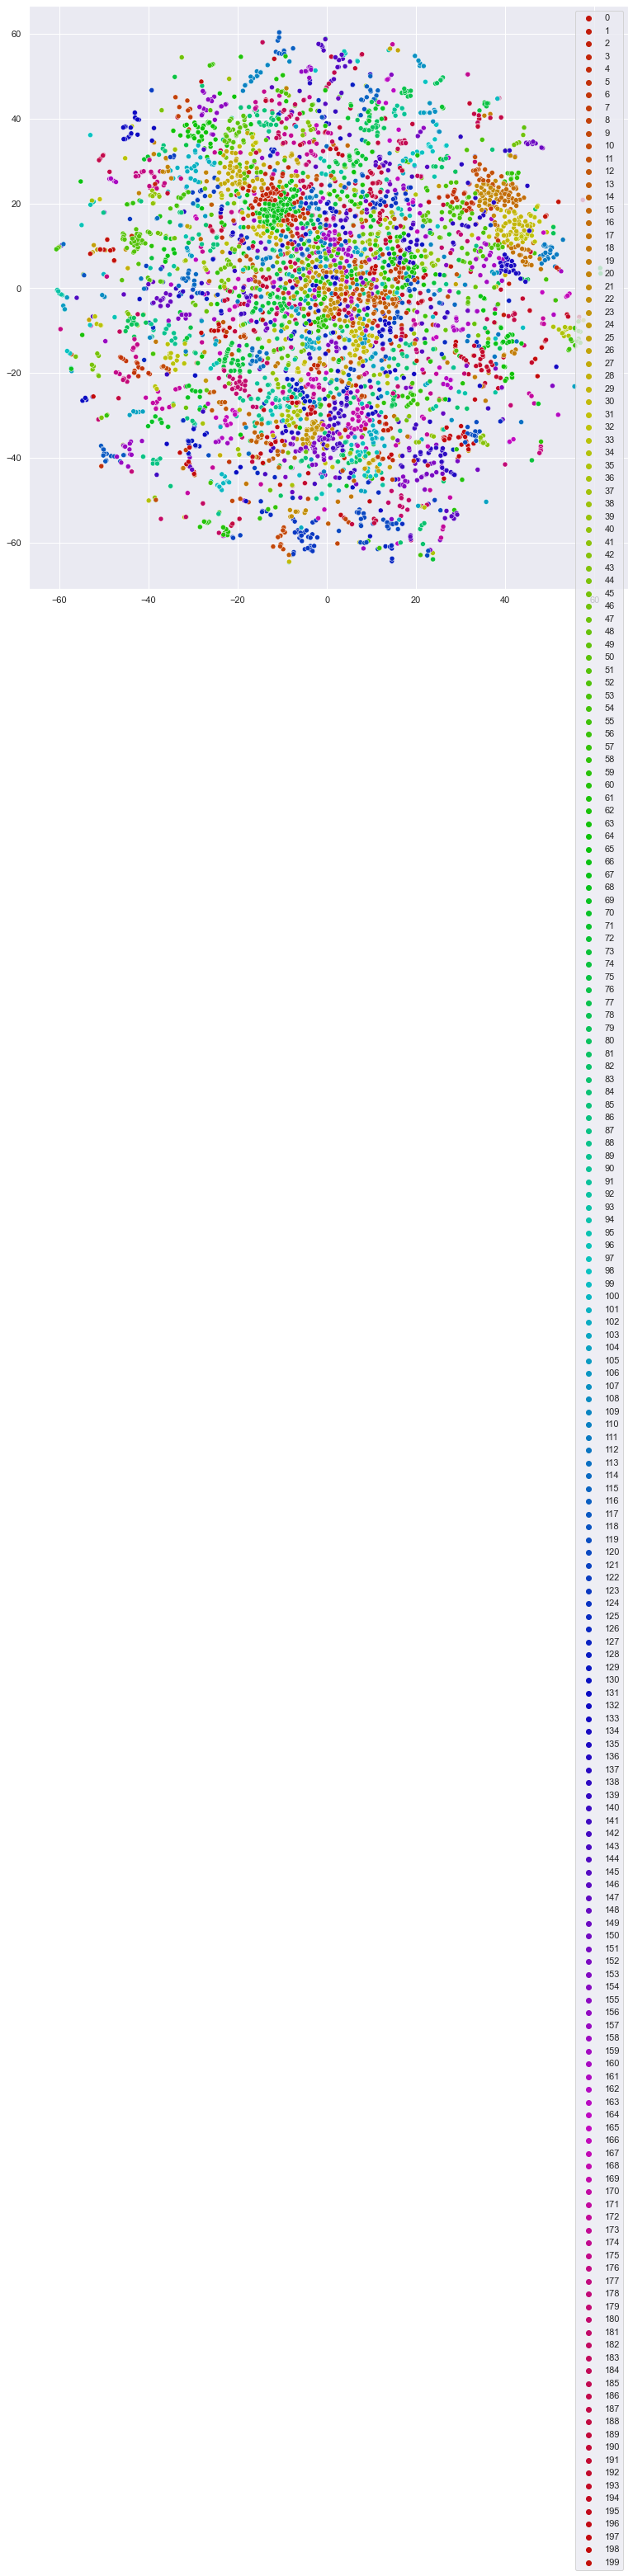

In [147]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(rc={'figure.figsize':(13,13)})

palette = sns.hls_palette(k, l=.4, s=.9)

sns.scatterplot(tsne_results[:,0], tsne_results[:,1], hue=y_pred, palette=palette, legend='full')

In [30]:
#Find nearest neighbours of a term
from scipy.spatial import distance
def findNearestNeighbour(term, vectors):
    term_vec = vectors[term]
    tmp = {k: v for k,v in sorted(vectors.items(), key=lambda item: distance.cosine(term_vec, item[1]))}
    nearest = list({k: tmp[k] for k in list(tmp)[:10]}.keys())

    return nearest



In [41]:
for center in kmeans.cluster_centers_:
    for k,v in vectors.items():
        if(v.all == center.all):
            print(k)

In [31]:
def findNearestNeighbourVec(term_vec, vectors):
    tmp = {k: v for k,v in sorted(vectors.items(), key=lambda item: distance.cosine(term_vec, item[1]))}
    nearest = list({k: tmp[k] for k in list(tmp)[:10]}.keys())

    return nearest

In [230]:
centers = kmeans.cluster_centers_
n = findNearestNeighbourVec(centers[0], vectors)
labels = list(range(len(centers)))
neighbourTerms2 = pd.DataFrame({0:n})
for i in range(len(centers)):
    n = findNearestNeighbourVec(centers[i], vectors)
    #print(i,n)
    neighbourTerms2[i] = n

neighbourTerms2

/var/folders/9k/9qw6yrzx6493tcr085_zrwj40000gn/T/ipykernel_72686/2098785193.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  neighbourTerms2[i] = n


,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,mnist,harmful,implemented,technique-based,frequently,model-performance,data-privacy,existing-works,vertices,concerns,...,formed,achievable,wireless,image-analysis,orthogonal-frequency-division,feature-space,considering,recent-years,autonomous,costly
1,digit,detrimental,implementation,solution-based,prevalent,generalizability,confidentiality,mainly-focus,graph,ethical,...,sparsely,proposed-scheme,wireless-networks,remote-sensing,ofdm,low-dimensional,characteristics,tremendous,mobile-robot,prohibitively
2,svhn,hypothesize,implement,proposed-based,likely,improve-generalization,integrity,relied,edges,raises,...,partitioned,relay,cellular-networks,medical-imaging,multiplexing,manifold,effect,witnessed,robotic,time-consuming
3,digits,undesirable,hardware,technique-called,occur,generalization-ability,protecting,previous-works,graphs,security-privacy,...,grouped,achievable-rate,vehicular,hyperspectral,multiple-access,latent-space,individual,past-years,navigation,expensive
4,handwritten,grammatical,prototype,proposed-paper,numerous,prediction-performance,user-data,prior-works,induced,risks,...,nonnegative,gain,communications,medical-images,mimo,high-dimensional,specific,significant-progress,robot,infeasible
5,imagenet,biases,integrated,work-introduces,cause,achieve-better,privacy,previous-research,subgraph,raise,...,densely,outage-probability,ad-hoc-networks,image-segmentation,multiuser,embedding-space,different,advances,robots,cumbersome
6,datasets-including,mistakes,implementations,paper-new,appear,improve-model,sensitive-data,largely,partition,faced,...,rectangular,dof,ad-hoc,medical-image,massive-mimo,data-points,addition,achieved-great,mobile-robots,computationally-intensive
7,image-datasets,unobserved,design,statistical-properties,unfortunately,predictive-performance,protect,existing-studies,tree,challenges,...,isolated,relaying,cellular-network,pathology,spectral-efficiency,latent-representation,depending,progress,autonomous-vehicles,impractical
8,benchmark-dataset,problematic,architecture,based-novel,worldwide,computational-efficiency,sensitive-information,current-approaches,subgraphs,technical,...,neighboring,transmission,wireless-network,biomedical,random-access,latent,impact,advancements,humanoid,prohibitive
9,experiments-conducted,gender,built,paper-presents-new,frequent,significantly-improves,differential-privacy,recent-works,paths,addressing,...,forming,scheme,wireless-communication,microscopy,downlink,manifolds,effects,gained,robotic-systems,laborious


In [32]:
zip_iterator = zip(termDict.keys(), y_pred)

value_clusters = dict(zip_iterator)

In [33]:
clusters = {}
for term in value_clusters.items():
    clusters[term[1]] = []
for term in value_clusters.items():
    clusters[term[1]].append(term[0])

In [34]:
for i in clusters.keys():
    print(i,clusters[i])

141 ['network', 'networks', 'nodes', 'node', 'routing', 'consensus', 'links', 'connectivity', 'network-structure', 'complex-networks', 'neighbors', 'community-detection', 'network-topology', 'connections', 'routes', 'nodes-network', 'forwarding', 'network-nodes', 'degree-distribution', 'community-structure', 'neighborhood']
58 ['performance', 'improve', 'accuracy', 'quality', 'achieve', 'better', 'achieves', 'robustness', 'achieving', 'improving', 'achieved', 'scalability', 'improvement', 'improves', 'improvements', 'maintaining', 'reliability', 'improved', 'performances', 'faster', 'efficiency', 'overall', 'good', 'compared', 'speed', 'greatly', 'lower', 'higher', 'increased']
156 ['learning', 'training', 'classification', 'labels', 'unsupervised', 'label', 'supervised', 'supervision', 'transfer-learning', 'supervised-learning', 'representation-learning', 'data-augmentation', 'domain-adaptation', 'unsupervised-learning', 'unlabeled-data', 'active-learning', 'contrastive', 'feature-lea

In [35]:
print(clusters[41])

['machine-learning', 'artificial-intelligence', 'machine-learning-models', 'deep-learning-models', 'methodologies', 'machine-learning-ml', 'machine-learning-algorithms', 'ml', 'machine-learning-techniques', 'artificial-intelligence-ai', 'deep-learning-methods', 'artificial-neural-networks', 'contemporary', 'pipelines', 'deep-learning-based', 'machine-learning-methods', 'sophisticated', 'explainable', 'dl', 'advanced', 'deep-learning-techniques', 'deep-learning-dl', 'data-science', 'application-domains', 'based-deep-learning', 'decision-support', 'machine-learning-applications', 'use-machine-learning', 'deep-learning-algorithms']


Number of hits per topic

In [36]:
#Number of word from certain cluster in the abstract
from collections import Counter

def topicHits(text, value_clusters):
    topics = {}
    wordDict = Counter(text)
    for word in wordDict.keys():
        if(word in value_clusters.keys()):
            topics[value_clusters[word]] = wordDict[word]
    return topics

In [37]:
#Just return which topics were hit
def pureTopics(topics):
    return topics.keys()

In [38]:
def makeList(text):
    tmp = text.split(',')
    for i in range(len(tmp)):
        tmp[i] = tmp[i].replace('[','')
        tmp[i] = tmp[i].replace("'",'')
        tmp[i] = tmp[i].replace(']','')
        tmp[i] = tmp[i].replace(" ",'')
    return tmp

In [39]:
df_combined = pd.read_csv('../Data/df_combined.csv')

In [40]:
def string2list(s):
    s = s.replace('[', '')
    s = s.replace(']', '')
    s = s.replace(' ', '')
    s = s.replace("'", '')
    s = s.replace('"', '')
    terms = s.split(',')
    return terms

In [41]:
df_combined

,abstract,list_categories,main_categories,year,doubleFilteredAbstracts,topic_hits,topics,subfield
0,This paper studies the impact of a transmitt...,"['cs.IT', 'math.IT']","['cs', 'math']",2018,"['paper-studies', 'impact', 'transmitter', 'mo...","{13: 1, 196: 1, 99: 1, 48: 4, 102: 3, 19: 1, 1...","dict_keys([13, 196, 99, 48, 102, 19, 184, 23, ...",IT
1,Deep Reinforcement Learning (DRL) is conside...,"['cs.LG', 'cs.AI']",['cs'],2021,"['deep-reinforcement-learning', 'drl', 'framew...","{132: 3, 23: 1, 58: 1, 9: 1, 119: 1, 152: 1, 8...","dict_keys([132, 23, 58, 9, 119, 152, 81, 154, ...",LG
2,Ad and tracking blocking extensions are popu...,['cs.CR'],['cs'],2018,"['tracking', 'blocking', 'popular', 'tools', '...","{129: 2, 59: 3, 142: 1, 102: 1, 58: 1, 60: 1, ...","dict_keys([129, 59, 142, 102, 58, 60, 6, 25, 1...",CR
3,"We introduce a simple, geometric model of op...","['cs.SI', 'econ.TH']","['cs', 'econ']",2019,"['model', 'opinion', 'polarization', 'model', ...","{152: 1, 188: 1, 57: 1, 60: 1, 121: 1, 91: 1, ...","dict_keys([152, 188, 57, 60, 121, 91, 140, 196...",SI
4,Computer vision (CV) has achieved great succ...,['cs.CV'],['cs'],2020,"['computer-vision', 'achieved-great', 'success...","{197: 1, 14: 1, 70: 1, 162: 1, 142: 2, 81: 1, ...","dict_keys([197, 14, 70, 162, 142, 81, 22, 82, ...",CV
...,...,...,...,...,...,...,...,...
99995,The number partitioning problem is the probl...,"['cs.DS', 'cs.IT', 'math.CO', 'math.IT']","['cs', 'math']",2020,"['number', 'partitioning', 'problem-problem', ...","{91: 1, 8: 2, 101: 1, 144: 1, 88: 2, 152: 1, 5...","dict_keys([91, 8, 101, 144, 88, 152, 50, 23, 1...",DS
99996,"As life expectancy is mostly increasing, the...",['cs.GR'],['cs'],2020,"['life', 'disorders', 'constantly', 'growing',...","{120: 1, 55: 1, 73: 1, 138: 1, 58: 1, 196: 1, ...","dict_keys([120, 55, 73, 138, 58, 196, 97, 4, 4...",GR
99997,We study descriptive complexity properties o...,['cs.FL'],['cs'],2017,"['study', 'descriptive', 'complexity', 'proper...","{140: 1, 10: 1, 84: 1, 88: 1, 104: 7, 36: 1, 9...","dict_keys([140, 10, 84, 88, 104, 36, 94, 125, ...",FL
99998,"We introduce a binary, relaxed gradient, tru...","['quant-ph', 'cs.NA', 'math.DS', 'math.NA', 'm...","['quant-ph', 'cs', 'math']",2021,"['introduce', 'binary', 'optimizing', 'pulse',...","{23: 1, 96: 2, 176: 1, 130: 1, 36: 1, 114: 1, ...","dict_keys([23, 96, 176, 130, 36, 114, 18, 88, ...",NaN


In [42]:
df_combined['list_categories'] = df_combined.list_categories.apply(string2list)

In [43]:
df_combined['main_categories'] = df_combined.main_categories.apply(string2list)

In [44]:
df_combined['doubleFilteredAbstracts'] = df_combined.doubleFilteredAbstracts.apply(string2list)

In [45]:
def str2json(s):
    d = {}
    s = s.replace('{', '')
    s = s.replace('}', '')
    s = s.replace("'", '')
    s = s.replace('"', '')
    s = s.replace(' ', '')
    l = s.split(',')
    for term in l:
        pair = term.split(':')
        if(len(pair)>1):
            d[int(pair[0])] = int(pair[1])
    return d

In [46]:
def topics2list(s):
    s = s.replace('dict_keys([', '')
    s = s.replace('])','')
    s = s.replace(' ', '')
    s = s.replace("'", '')
    l = s.split(',')
    if(l == ['']):
        return []
    l = [int(x) for x in l]
    return l

In [47]:
df_combined['topic_hits'] = df_combined.topic_hits.apply(str2json)

In [48]:
df_combined['topics'] = df_combined.topics.apply(topics2list)

In [49]:
df_combined

,abstract,list_categories,main_categories,year,doubleFilteredAbstracts,topic_hits,topics,subfield
0,This paper studies the impact of a transmitt...,"[cs.IT, math.IT]","[cs, math]",2018,"[paper-studies, impact, transmitter, molecule,...","{13: 1, 196: 1, 99: 1, 48: 4, 102: 3, 19: 1, 1...","[13, 196, 99, 48, 102, 19, 184, 23, 139, 176, ...",IT
1,Deep Reinforcement Learning (DRL) is conside...,"[cs.LG, cs.AI]",[cs],2021,"[deep-reinforcement-learning, drl, framework, ...","{132: 3, 23: 1, 58: 1, 9: 1, 119: 1, 152: 1, 8...","[132, 23, 58, 9, 119, 152, 81, 154, 197, 151, ...",LG
2,Ad and tracking blocking extensions are popu...,[cs.CR],[cs],2018,"[tracking, blocking, popular, tools, improving...","{129: 2, 59: 3, 142: 1, 102: 1, 58: 1, 60: 1, ...","[129, 59, 142, 102, 58, 60, 6, 25, 136, 105, 4...",CR
3,"We introduce a simple, geometric model of op...","[cs.SI, econ.TH]","[cs, econ]",2019,"[model, opinion, polarization, model, politica...","{152: 1, 188: 1, 57: 1, 60: 1, 121: 1, 91: 1, ...","[152, 188, 57, 60, 121, 91, 140, 196, 170, 25,...",SI
4,Computer vision (CV) has achieved great succ...,[cs.CV],[cs],2020,"[computer-vision, achieved-great, success, sem...","{197: 1, 14: 1, 70: 1, 162: 1, 142: 2, 81: 1, ...","[197, 14, 70, 162, 142, 81, 22, 82, 123, 91, 1...",CV
...,...,...,...,...,...,...,...,...
99995,The number partitioning problem is the probl...,"[cs.DS, cs.IT, math.CO, math.IT]","[cs, math]",2020,"[number, partitioning, problem-problem, partit...","{91: 1, 8: 2, 101: 1, 144: 1, 88: 2, 152: 1, 5...","[91, 8, 101, 144, 88, 152, 50, 23, 10, 54, 27,...",DS
99996,"As life expectancy is mostly increasing, the...",[cs.GR],[cs],2020,"[life, disorders, constantly, growing, improvi...","{120: 1, 55: 1, 73: 1, 138: 1, 58: 1, 196: 1, ...","[120, 55, 73, 138, 58, 196, 97, 4, 40, 6, 102,...",GR
99997,We study descriptive complexity properties o...,[cs.FL],[cs],2017,"[study, descriptive, complexity, properties, l...","{140: 1, 10: 1, 84: 1, 88: 1, 104: 7, 36: 1, 9...","[140, 10, 84, 88, 104, 36, 94, 125, 174, 38, 4...",FL
99998,"We introduce a binary, relaxed gradient, tru...","[quant-ph, cs.NA, math.DS, math.NA, math.OC]","[quant-ph, cs, math]",2021,"[introduce, binary, optimizing, pulse, sequenc...","{23: 1, 96: 2, 176: 1, 130: 1, 36: 1, 114: 1, ...","[23, 96, 176, 130, 36, 114, 18, 88, 102, 2, 91...",NaN


In [238]:
# Don't run
df_combined['doubleFilteredAbstracts'] = list(cs_dict_filtered['filteredAbstracts'].values())

In [50]:
df_combined['topic_hits'] = df_combined.doubleFilteredAbstracts.apply(topicHits, value_clusters=value_clusters)
df_combined['topics'] = df_combined.topic_hits.apply(pureTopics)
df_combined

,abstract,list_categories,main_categories,year,doubleFilteredAbstracts,topic_hits,topics,subfield
0,This paper studies the impact of a transmitt...,"[cs.IT, math.IT]","[cs, math]",2018,"[paper-studies, impact, transmitter, molecule,...","{13: 1, 196: 1, 99: 1, 48: 4, 102: 3, 19: 1, 1...","(13, 196, 99, 48, 102, 19, 184, 23, 139, 176, ...",IT
1,Deep Reinforcement Learning (DRL) is conside...,"[cs.LG, cs.AI]",[cs],2021,"[deep-reinforcement-learning, drl, framework, ...","{132: 3, 23: 1, 58: 1, 9: 1, 119: 1, 152: 1, 8...","(132, 23, 58, 9, 119, 152, 81, 154, 197, 151, ...",LG
2,Ad and tracking blocking extensions are popu...,[cs.CR],[cs],2018,"[tracking, blocking, popular, tools, improving...","{129: 2, 59: 3, 142: 1, 102: 1, 58: 1, 60: 1, ...","(129, 59, 142, 102, 58, 60, 6, 25, 136, 105, 4...",CR
3,"We introduce a simple, geometric model of op...","[cs.SI, econ.TH]","[cs, econ]",2019,"[model, opinion, polarization, model, politica...","{152: 1, 188: 1, 57: 1, 60: 1, 121: 1, 91: 1, ...","(152, 188, 57, 60, 121, 91, 140, 196, 170, 25,...",SI
4,Computer vision (CV) has achieved great succ...,[cs.CV],[cs],2020,"[computer-vision, achieved-great, success, sem...","{197: 1, 14: 1, 70: 1, 162: 1, 142: 2, 81: 1, ...","(197, 14, 70, 162, 142, 81, 22, 82, 123, 91, 1...",CV
...,...,...,...,...,...,...,...,...
99995,The number partitioning problem is the probl...,"[cs.DS, cs.IT, math.CO, math.IT]","[cs, math]",2020,"[number, partitioning, problem-problem, partit...","{91: 1, 8: 2, 101: 1, 144: 1, 88: 2, 152: 1, 5...","(91, 8, 101, 144, 88, 152, 50, 23, 10, 54, 27,...",DS
99996,"As life expectancy is mostly increasing, the...",[cs.GR],[cs],2020,"[life, disorders, constantly, growing, improvi...","{120: 1, 55: 1, 73: 1, 138: 1, 58: 1, 196: 1, ...","(120, 55, 73, 138, 58, 196, 97, 4, 40, 6, 102,...",GR
99997,We study descriptive complexity properties o...,[cs.FL],[cs],2017,"[study, descriptive, complexity, properties, l...","{140: 1, 10: 1, 84: 1, 88: 1, 104: 7, 36: 1, 9...","(140, 10, 84, 88, 104, 36, 94, 125, 174, 38, 4...",FL
99998,"We introduce a binary, relaxed gradient, tru...","[quant-ph, cs.NA, math.DS, math.NA, math.OC]","[quant-ph, cs, math]",2021,"[introduce, binary, optimizing, pulse, sequenc...","{23: 1, 96: 2, 176: 1, 130: 1, 36: 1, 114: 1, ...","(23, 96, 176, 130, 36, 114, 18, 88, 102, 2, 91...",NaN


In [51]:
from collections import Counter

In [52]:
# Topic hits per year
hits_per_year = {}
for index, row in df_combined.iterrows():
    if(row['year'] in hits_per_year.keys()):
        hits_per_year[row['year']] = Counter(hits_per_year[row['year']]) + Counter(row['topics'])
    else:
        hits_per_year[row['year']] = Counter(row['topics'])
for key in hits_per_year.keys():
    hits_per_year[key] = {k: v for k, v in sorted(dict(hits_per_year[key]).items(), key=lambda item: item[1], reverse=True)}

hits_per_year

{2018: {152: 8082,
  140: 7733,
  142: 7617,
  23: 7378,
  169: 7314,
  91: 6989,
  196: 6865,
  81: 6601,
  58: 5869,
  102: 5713,
  97: 5204,
  36: 5108,
  111: 4983,
  128: 4478,
  14: 4354,
  25: 4320,
  88: 3829,
  78: 3781,
  2: 3235,
  136: 3022,
  174: 2957,
  31: 2893,
  18: 2839,
  156: 2783,
  141: 2771,
  176: 2731,
  123: 2690,
  68: 2642,
  54: 2628,
  90: 2573,
  162: 2299,
  168: 2247,
  84: 2186,
  46: 2186,
  166: 2158,
  72: 2141,
  197: 2084,
  138: 2048,
  30: 1868,
  103: 1757,
  96: 1727,
  16: 1725,
  151: 1709,
  51: 1704,
  8: 1691,
  13: 1599,
  15: 1595,
  40: 1542,
  120: 1537,
  173: 1503,
  85: 1493,
  114: 1473,
  189: 1469,
  180: 1449,
  41: 1427,
  60: 1398,
  19: 1380,
  179: 1376,
  191: 1367,
  101: 1362,
  3: 1344,
  4: 1341,
  9: 1331,
  7: 1312,
  94: 1311,
  165: 1306,
  133: 1300,
  148: 1280,
  29: 1273,
  86: 1273,
  74: 1262,
  22: 1259,
  21: 1250,
  32: 1198,
  73: 1187,
  27: 1181,
  170: 1171,
  33: 1160,
  62: 1158,
  190: 1156,
  159:

In [53]:
hits_per_year = {k: v for k, v in sorted(hits_per_year.items(), key=lambda item: item[0], reverse=True)}
hits_per_year

{2021: {152: 13017,
  142: 12172,
  140: 12035,
  23: 11696,
  169: 11247,
  81: 11012,
  196: 10849,
  91: 10406,
  58: 9805,
  102: 8936,
  97: 8644,
  111: 8154,
  36: 8023,
  128: 7152,
  25: 7020,
  14: 7000,
  78: 6487,
  88: 5637,
  2: 5312,
  136: 5137,
  156: 5003,
  123: 4706,
  176: 4542,
  68: 4399,
  18: 4382,
  31: 4361,
  174: 4232,
  90: 4122,
  54: 4092,
  72: 3695,
  141: 3647,
  197: 3585,
  162: 3518,
  168: 3502,
  166: 3468,
  16: 3286,
  138: 3154,
  46: 3151,
  30: 3141,
  189: 2991,
  84: 2984,
  51: 2831,
  103: 2766,
  120: 2701,
  41: 2660,
  151: 2658,
  85: 2642,
  9: 2592,
  29: 2578,
  13: 2551,
  96: 2520,
  114: 2503,
  15: 2491,
  133: 2452,
  22: 2442,
  173: 2429,
  7: 2418,
  32: 2279,
  8: 2278,
  40: 2239,
  86: 2162,
  180: 2119,
  21: 2088,
  107: 2050,
  179: 2045,
  148: 2021,
  3: 2013,
  101: 2010,
  4: 1996,
  62: 1965,
  124: 1960,
  191: 1955,
  170: 1941,
  165: 1909,
  73: 1899,
  48: 1866,
  181: 1851,
  60: 1849,
  10: 1843,
  59: 18

In [54]:
#Plotting
# 2021: {26: 2100}
# x axis: 2021, y axis: 2100, line: 26
def plottingParams(hits_per_year):
    k = len(set(y_pred))
    min_yr = int(min(set(hits_per_year.keys())))
    max_yr = int(max(set(hits_per_year.keys())))
    yrs = max_yr-min_yr+1
    list_years = list(hits_per_year.keys())
    list_years.reverse()
    x_plotting = np.array(list(range(min_yr, max_yr+1)))
    y_plotting = np.zeros((k,yrs))
    for year in hits_per_year.keys():
        for line in hits_per_year[year].keys():
            y_plotting[line][int(year)-min_yr] = hits_per_year[year][line]
    return x_plotting, y_plotting

In [55]:
x_plotting, y_plotting = plottingParams(hits_per_year)
#print(x_plotting[1])

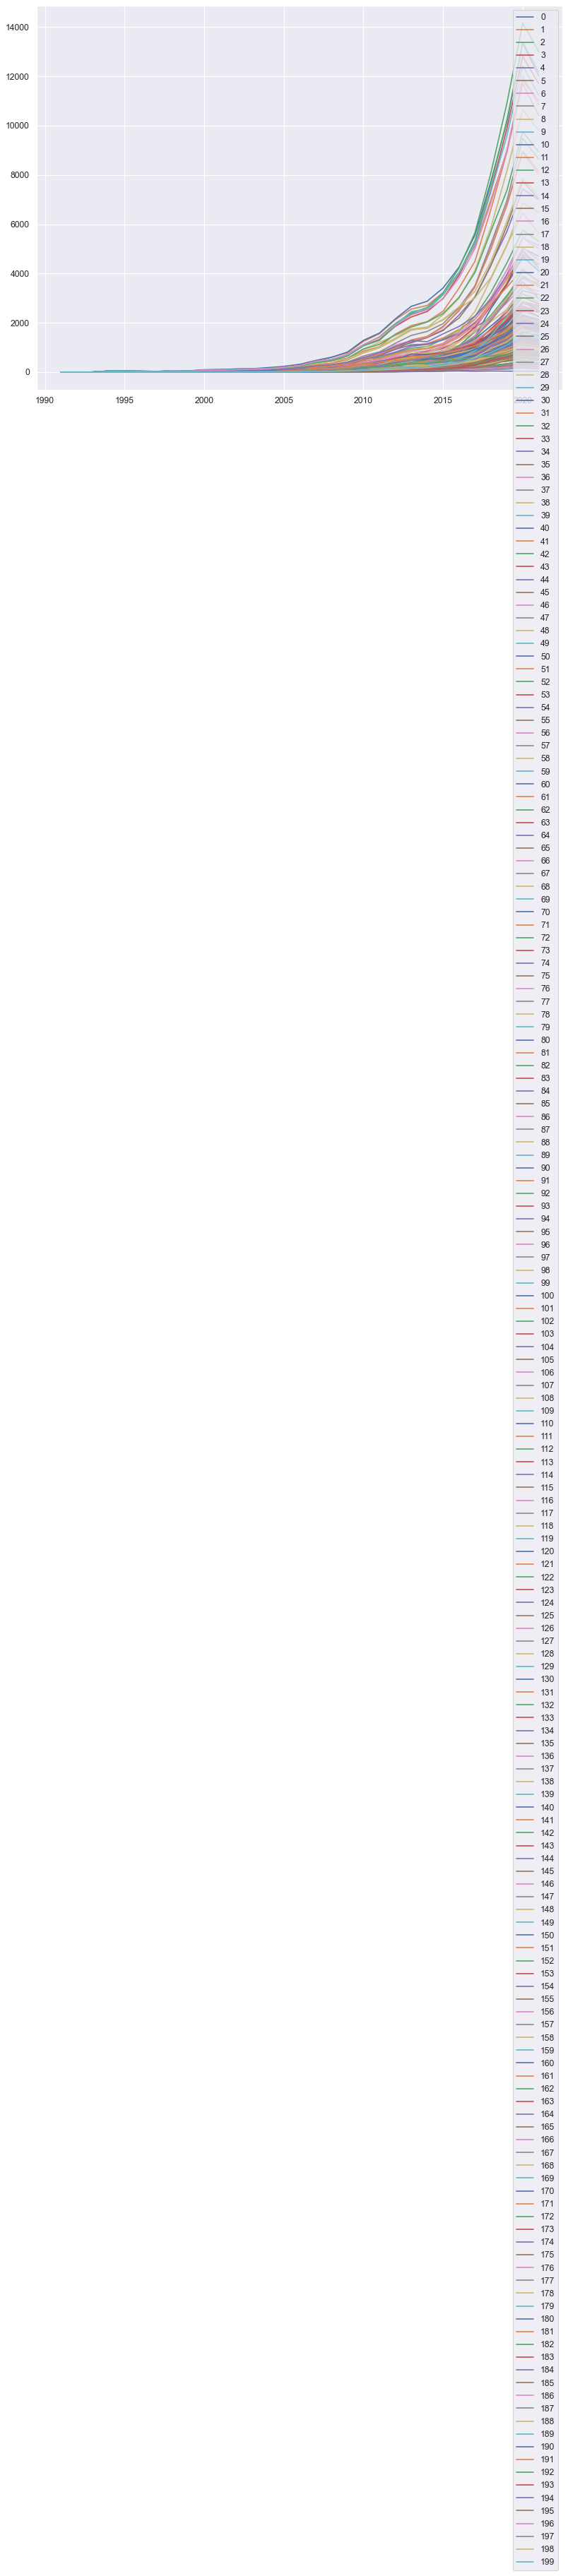

In [56]:
k = len(set(y_pred))
plt.figure(figsize=(12, 9), dpi=80)
for i in range(k):
    plt.plot(x_plotting, y_plotting[i], label=i)
plt.legend()


Normalize topics over time

In [57]:
# Find how many abstracts there are per year
abstracts_per_year = {}
for index, row in df_combined.iterrows():
    if(row['year'] in abstracts_per_year.keys()):
        abstracts_per_year[row['year']] += 1
    else:
        abstracts_per_year[row['year']] = 1
#for key in abstracts_per_year.keys():
#    abstracts_per_year[key] = {k: v for k, v in sorted(dict(abstracts_per_year[key]).items(), key=lambda item: item[1], reverse=True)}

In [58]:
abstracts_per_year

{2018: 10958,
 2021: 16586,
 2019: 14320,
 2020: 18425,
 2012: 3215,
 2017: 7939,
 2010: 1920,
 2014: 4121,
 2000: 128,
 2016: 6176,
 2007: 760,
 2013: 3918,
 2015: 4891,
 2011: 2360,
 2008: 946,
 2009: 1223,
 1995: 77,
 2001: 154,
 2002: 186,
 2005: 366,
 1998: 90,
 2006: 495,
 2003: 221,
 1996: 61,
 2004: 260,
 1997: 45,
 1994: 69,
 1999: 87,
 1991: 1,
 1993: 2}

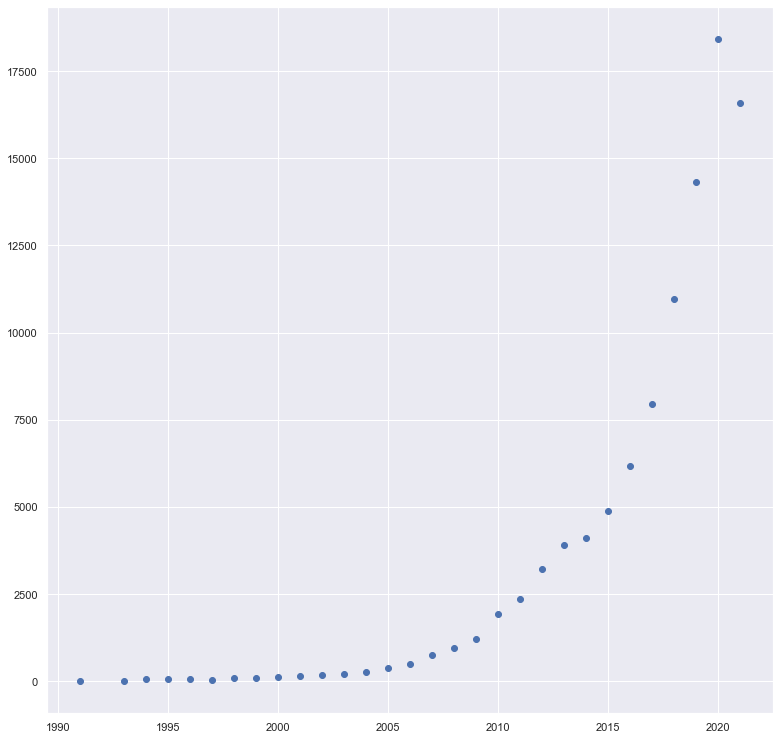

In [156]:
pyplot.scatter(list(abstracts_per_year.keys()), list(abstracts_per_year.values()))

In [60]:
hits_normalized = {}
for year in hits_per_year.keys():
    total = abstracts_per_year[year]
    hits_normalized[int(year)] = {}
    for key in hits_per_year[year].keys():
        hits_normalized[int(year)][key] = hits_per_year[year][key]/total

In [61]:
hits_normalized

{2021: {152: 0.7848185216447606,
  142: 0.7338719401905222,
  140: 0.7256119618955745,
  23: 0.7051730375015073,
  169: 0.6781020137465332,
  81: 0.6639334378391415,
  196: 0.654105872422525,
  91: 0.6273965995417822,
  58: 0.5911612203062824,
  102: 0.5387676353551187,
  97: 0.5211624261425298,
  111: 0.49161943808030867,
  36: 0.48372121065959245,
  128: 0.43120704208368504,
  25: 0.4232485228505969,
  14: 0.4220426866031593,
  78: 0.3911129868563849,
  88: 0.33986494634028697,
  2: 0.320270107319426,
  136: 0.30971904015434704,
  156: 0.3016399372965151,
  123: 0.2837332690220668,
  176: 0.2738454117930785,
  68: 0.26522368262389967,
  18: 0.26419872181357773,
  31: 0.26293259375376826,
  174: 0.25515494995779575,
  90: 0.24852285059688894,
  54: 0.24671409622573254,
  72: 0.2227782467140962,
  141: 0.21988423972024598,
  197: 0.21614614735318943,
  162: 0.21210659592427347,
  168: 0.21114192692632341,
  166: 0.20909200530567948,
  16: 0.19811889545399736,
  138: 0.1901603762209092,

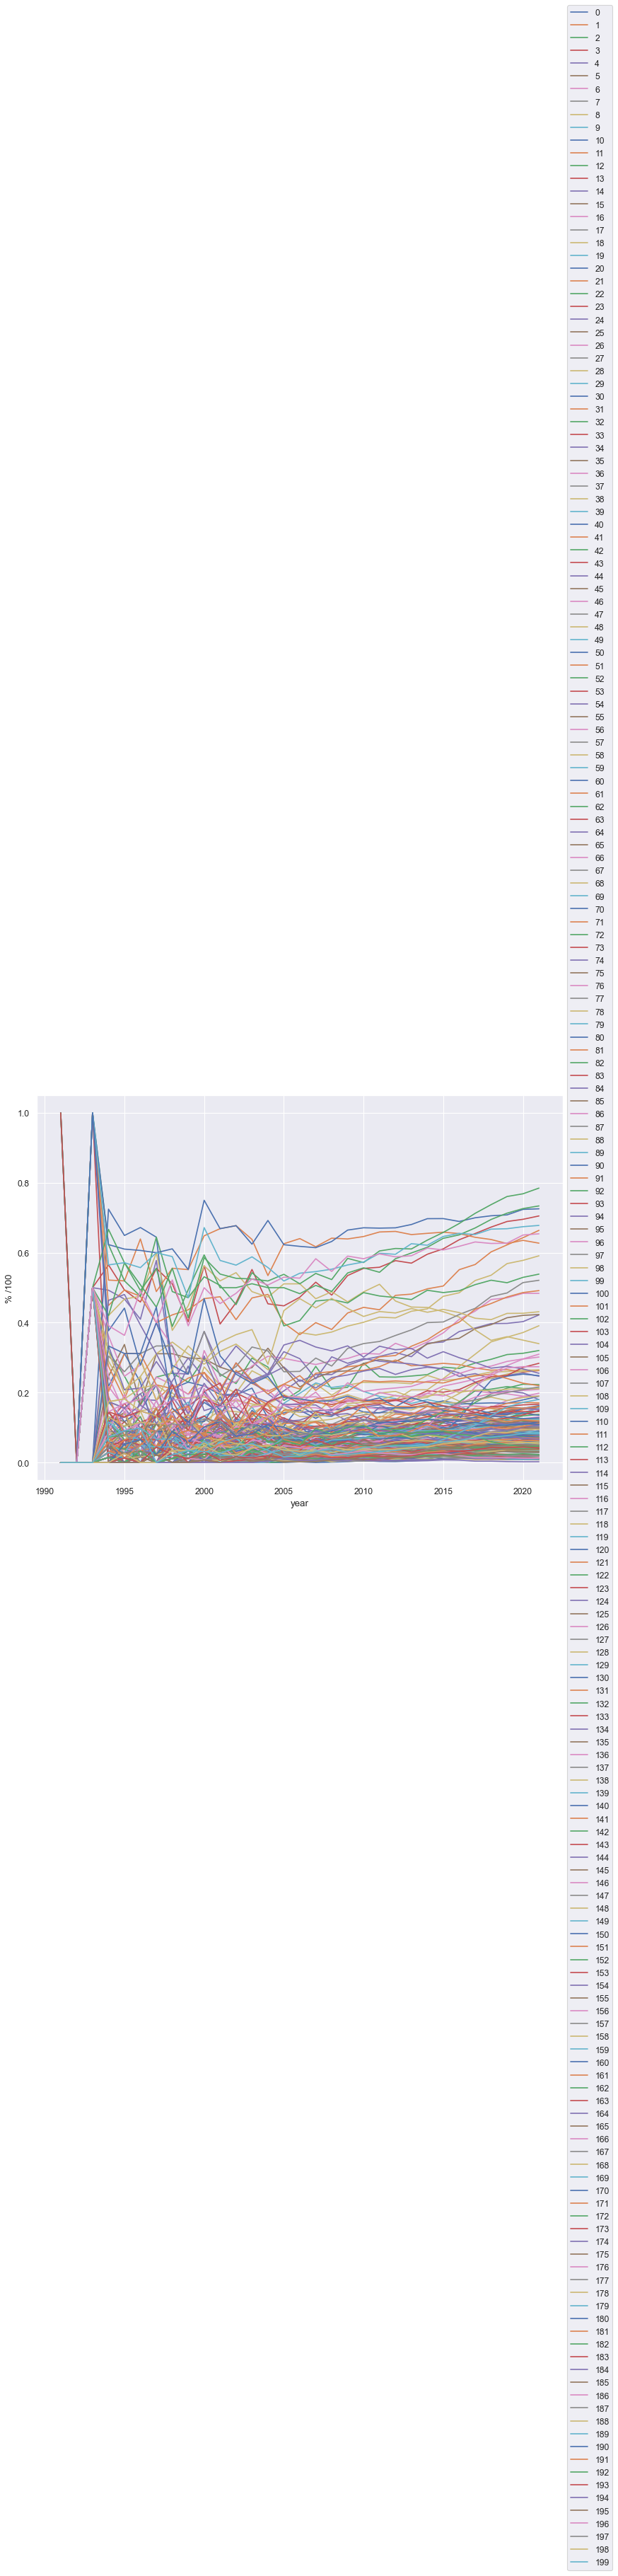

In [149]:
x_p, y_p = plottingParams(hits_normalized)
plt.figure(figsize=(12, 9), dpi=80)
for i in range(k):
    plt.plot(x_p, y_p[i], label=i)
plt.ylabel('% /100')
plt.xlabel('year')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

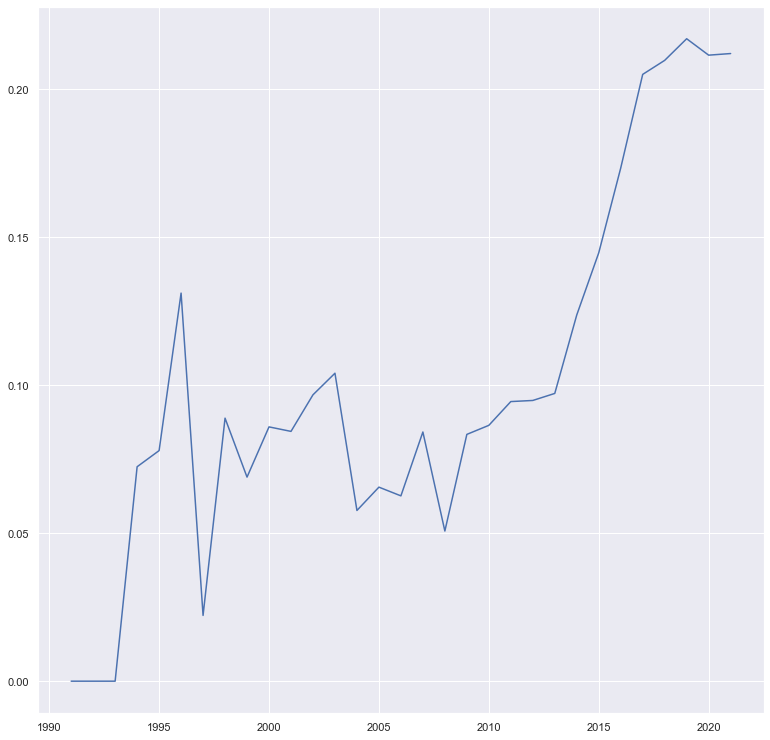

In [153]:
#41 ML
#162 image
#107 nlp
#116 gan
#187 fading channels
#163 neurons
plt.plot(x_p, y_p[162], label=i)

In [263]:
df_combined.to_csv("../Data/df_combined.csv", index=False)

ARIMA

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   31
Model:                 ARIMA(5, 1, 0)   Log Likelihood                  92.818
Date:                Sun, 06 Feb 2022   AIC                           -173.635
Time:                        17:49:00   BIC                           -165.228
Sample:                             0   HQIC                          -170.946
                                 - 31                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0672      0.288     -0.233      0.816      -0.632       0.498
ar.L2         -0.1655      0.269     -0.616      0.538      -0.692       0.361
ar.L3         -0.2600      0.315     -0.826      0.4

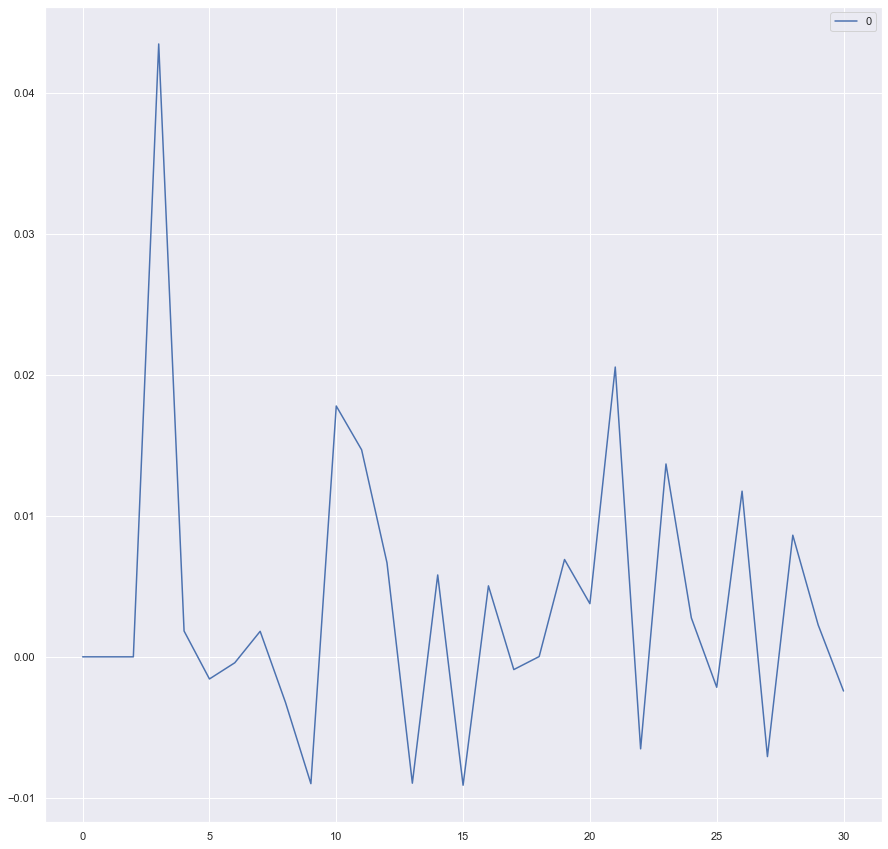

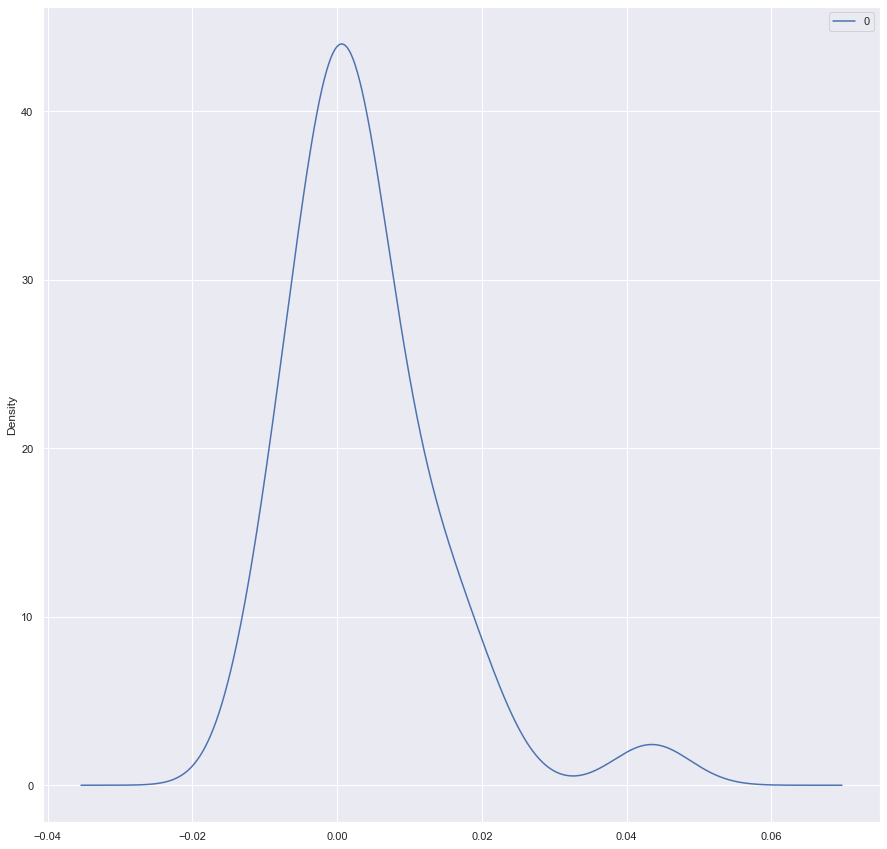

               0
count  31.000000
mean    0.003743
std     0.010578
min    -0.009110
25%    -0.001865
50%     0.001811
75%     0.006788
max     0.043478


In [64]:
from statsmodels.tsa.arima.model import ARIMA
series = y_p[37]
model = ARIMA(series, order=(5,1,0))
model_fit = model.fit()
print(model_fit.summary())
# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())


predicted=0.051247, expected=0.052119
predicted=0.045293, expected=0.068740


/Users/miamijovic/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/miamijovic/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=0.069506, expected=0.060745
predicted=0.051304, expected=0.070129


/Users/miamijovic/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=0.066150, expected=0.069311
predicted=0.071898, expected=0.068977


/Users/miamijovic/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/miamijovic/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=0.058493, expected=0.073813
predicted=0.077705, expected=0.069721
predicted=0.066827, expected=0.075838
predicted=0.074996, expected=0.077232
predicted=0.077938, expected=0.075546
Test RMSE: 0.011


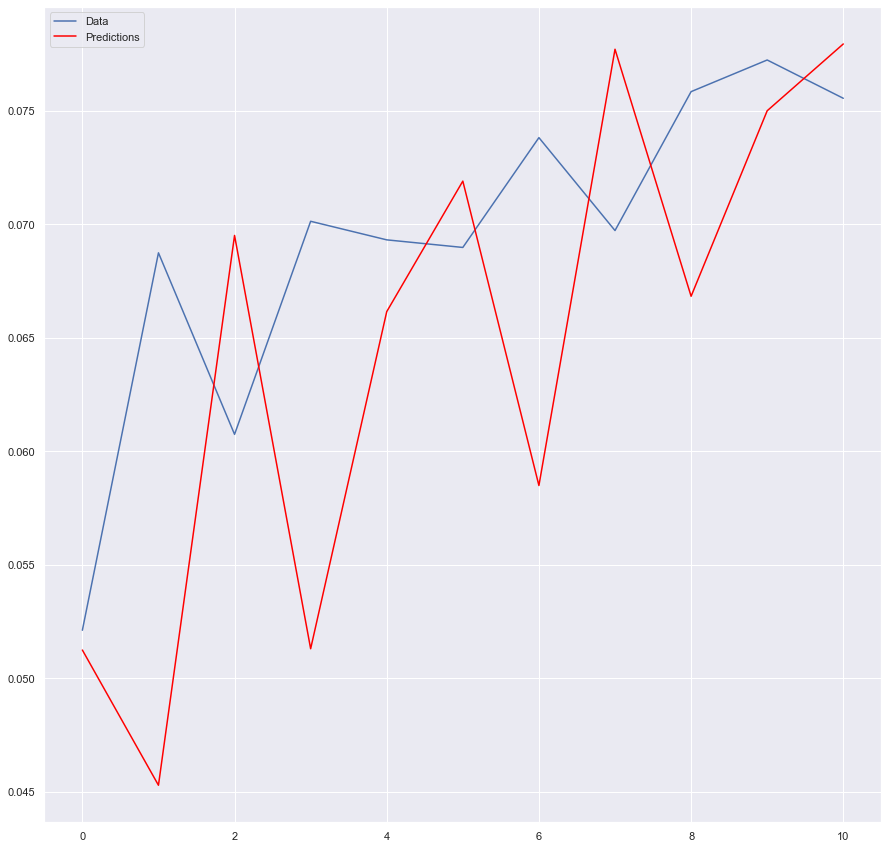

In [65]:
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error
from math import sqrt
X = series
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
	model = ARIMA(history, order=(5,1,0))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
pyplot.plot(test, label='Data')
pyplot.plot(predictions, color='red', label='Predictions')
pyplot.legend()
pyplot.show()


In [66]:
#ARIMA function
def arima_func(series):
    #Forcasting
    X = series
    size = int(len(X) * 0.66)
    train, test = X[0:size], X[size:len(X)]
    history = [x for x in train]
    predictions = list()
    # walk-forward validation
    for t in range(len(test)):
        model = ARIMA(history, order=(5,1,0))
        model_fit = model.fit()
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)
    # evaluate forecasts
    rmse = sqrt(mean_squared_error(test, predictions))
    
    return predictions


In [68]:
residuals_list = np.zeros(k)
test_list = np.zeros((k,len(test)))
predictions_list = np.zeros((k,len(predictions)))
rmse_list = np.zeros(k)

# len(y_p) = number of clusters
for i in range(len(y_p)):
    #if(i != 36):
    predictions_list[i][:] = arima_func(y_p[i])

/Users/miamijovic/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/miamijovic/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/miamijovic/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/miamijovic/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/miamijovic/opt/anaconda3/

Find topic occurances per subfield codes

In [69]:
predictions_list[152]

array([0.55896971, 0.57926689, 0.59949745, 0.59569116, 0.62638544,
       0.65245336, 0.66486724, 0.69091436, 0.71690903, 0.74004588,
       0.75117224])

In [ ]:
df_combined.list_categories = df_combined['list_categories'].apply(makeList)

In [70]:
def findSubCat(categories):
    if(categories[0].split(".")[0] == "cs"):
        return categories[0].split(".")[1]
    else:
        return ''

In [296]:
df_combined['subfield'] = df_combined['list_categories'].apply(findSubCat)

In [71]:
def findSubjectTopicHits(topic, f):
    hits_per_field = {}
    for index, row in df_combined.iterrows():
        if(row[f] in hits_per_field.keys()):
            hits_per_field[row[f]] = Counter(hits_per_field[row[f]]) + Counter(row[topic])
        else:
            hits_per_field[row[f]] = Counter(row[topic])
    for key in hits_per_field.keys():
        hits_per_field[key] = {k: v for k, v in sorted(dict(hits_per_field[key]).items(), key=lambda item: item[1], reverse=True)}

    hits_normalized_field = {}
    for field in hits_per_field.keys():
        total = 0
        hits_normalized_field[field] = {}
        for key in hits_per_field[field].keys():
            total += hits_per_field[field][key]
        for key in hits_per_field[field].keys():
            hits_normalized_field[field][key] = hits_per_field[field][key]/total

    return hits_per_field, hits_normalized_field


In [72]:
subject_no, subject_topic_hits = findSubjectTopicHits('topic_hits', 'subfield')
topics_no, subject_topics = findSubjectTopicHits('topics', 'subfield')

In [73]:
sum(subject_topics['IT'].values())

1.0

In [74]:
topics_no['IT']

{91: 4801,
 196: 4645,
 140: 4640,
 152: 4628,
 23: 4380,
 169: 4292,
 128: 4287,
 19: 4179,
 174: 4159,
 142: 4135,
 58: 3972,
 88: 3459,
 191: 3422,
 102: 3212,
 54: 2809,
 144: 2737,
 81: 2686,
 84: 2606,
 168: 2521,
 111: 2388,
 36: 2311,
 67: 2301,
 97: 2237,
 25: 2164,
 96: 2119,
 176: 2006,
 40: 1979,
 14: 1976,
 136: 1961,
 141: 1932,
 192: 1922,
 2: 1834,
 18: 1754,
 31: 1703,
 79: 1652,
 187: 1510,
 17: 1458,
 51: 1329,
 173: 1325,
 148: 1295,
 183: 1283,
 27: 1194,
 123: 1138,
 160: 1125,
 101: 1086,
 112: 1039,
 99: 1038,
 13: 989,
 92: 981,
 122: 980,
 63: 973,
 68: 970,
 60: 970,
 114: 965,
 3: 963,
 138: 955,
 30: 919,
 46: 905,
 53: 887,
 184: 884,
 190: 856,
 8: 835,
 89: 828,
 151: 798,
 78: 758,
 127: 751,
 197: 747,
 178: 745,
 85: 736,
 125: 735,
 75: 716,
 21: 715,
 166: 706,
 48: 698,
 22: 667,
 159: 645,
 16: 645,
 15: 622,
 130: 594,
 103: 583,
 64: 581,
 61: 564,
 59: 563,
 7: 560,
 73: 558,
 44: 557,
 66: 553,
 86: 544,
 24: 505,
 133: 483,
 161: 482,
 9: 471

In [75]:
subject_topics

{'IT': {91: 0.027685033013291813,
  196: 0.02678545685206009,
  140: 0.02675662428278984,
  152: 0.026687426116541246,
  23: 0.02525733068073696,
  169: 0.0247498774615806,
  128: 0.024721044892310355,
  19: 0.024098261396073004,
  174: 0.023982931118992013,
  142: 0.023844534786494825,
  58: 0.02290459302828475,
  88: 0.01994637142115734,
  191: 0.019733010408557506,
  102: 0.018522042499207105,
  54: 0.016198137416025143,
  144: 0.015782948418533574,
  81: 0.01548885621197705,
  84: 0.015027535103653086,
  168: 0.014537381426058876,
  111: 0.013770435083470287,
  36: 0.013326413516708473,
  67: 0.013268748378167978,
  97: 0.012899691491508809,
  25: 0.012478735980163193,
  96: 0.012219242856730964,
  176: 0.011567626791223366,
  40: 0.011411930917164028,
  14: 0.01139463137560188,
  136: 0.011308133667791136,
  141: 0.011140904766023701,
  192: 0.011083239627483204,
  2: 0.010575786408326847,
  18: 0.010114465300002883,
  31: 0.009820373093446357,
  79: 0.00952628088688983,
  187: 0.

In [348]:
with open('../Data/subject_topic_hits.txt', 'w', encoding='utf-8') as outfile:
    json.dump(str(subject_topic_hits), outfile)
with open('../Data/subject_topics.txt', 'w') as outfile:
    json.dump(str(subject_topics), outfile)   

Time series prediction on subject codes

In [76]:
# Topic hits per year
# In this and that year I have this many IT, this many LG ...
def yearHits():
    hits_per_year = {}
    for index, row in df_combined.iterrows():
        if(row['year'] in hits_per_year.keys()):
            if(row['subfield'] in hits_per_year[row['year']].keys()):
                hits_per_year[row['year']][row['subfield']] += 1
            else:
                hits_per_year[row['year']][row['subfield']] = 1
        else:
            hits_per_year[row['year']] = {row['subfield'] : 1}
    for key in hits_per_year.keys():
        hits_per_year[key] = {k: v for k, v in sorted(dict(hits_per_year[key]).items(), key=lambda item: item[1], reverse=True)}

    hits_normalized = {}
    for year in hits_per_year.keys():
        total = 0
        hits_normalized[int(year)] = {}
        for key in hits_per_year[year].keys():
            total += hits_per_year[year][key]
        for key in hits_per_year[year].keys():
            hits_normalized[int(year)][key] = hits_per_year[year][key]/total
    
    hits_per_year = {k: v for k, v in sorted(dict(hits_per_year).items(), key=lambda item: item[0], reverse=True)}
    hits_normalized = {k: v for k, v in sorted(dict(hits_normalized).items(), key=lambda item: item[0], reverse=True)}

    return hits_per_year, hits_normalized

In [77]:
# Basic non linguistic prediction
# Subject hits per year
subject_per_year, subject_per_year_norm = yearHits()

In [78]:
sum(subject_per_year_norm[2000].values())

1.0

In [355]:
with open('../Data/subject_per_year.json', 'w', encoding='utf-8') as outfile:
    json.dump(subject_per_year, outfile)
with open('../Data/subject_per_year_norm.json', 'w', encoding='utf-8') as outfile:
    json.dump(subject_per_year_norm, outfile)

In [144]:
df_dict = df_combined.to_dict()

In [350]:
df_combined.to_csv("../Data/df_combined.csv", index=False)

In [79]:
num_subjects = len(subject_topics)
num_subjects

40

In [80]:
# Convert dictionary
def year_to_subject(subject_per_year):
    year_per_subject = {}
    for year in subject_per_year.keys():
        d = subject_per_year[year]
        for subj in d.keys():
            if(subj in year_per_subject.keys()):
                year_per_subject[subj][year] = d[subj]
            else:
                year_per_subject[subj] = {year : d[subj]}
    return year_per_subject

In [81]:
year_per_subject = year_to_subject(subject_per_year)
year_per_subject_norm = year_to_subject(subject_per_year_norm)

In [82]:
print(year_per_subject_norm)

{nan: {2021: 0.21337272398408297, 2020: 0.24700135685210312, 2019: 0.2055167597765363, 2018: 0.14336557766015695, 2017: 0.12394508124448923, 2016: 0.13196243523316062, 2015: 0.14271110202412596, 2014: 0.14535306964329045, 2013: 0.1582440020418581, 2012: 0.18102643856920683, 2011: 0.2114406779661017, 2010: 0.14010416666666667, 2009: 0.10793131643499591, 2008: 0.10993657505285412, 2007: 0.09210526315789473, 2006: 0.11717171717171718, 2005: 0.1557377049180328, 2004: 0.16923076923076924, 2003: 0.14027149321266968, 2002: 0.15053763440860216, 2001: 0.14285714285714285, 2000: 0.1171875, 1999: 0.14942528735632185, 1998: 0.2777777777777778, 1997: 0.9111111111111111, 1996: 0.8852459016393442, 1995: 0.8961038961038961, 1994: 0.927536231884058}, 'LG': {2021: 0.1644157723381165, 2020: 0.15685210312075984, 2019: 0.16019553072625697, 2018: 0.11425442599014418, 2017: 0.0767099130872906, 2016: 0.06428108808290156, 2015: 0.06481292169290534, 2014: 0.04028148507643776, 2013: 0.04415518121490557, 2012: 0.

In [83]:
# Make subject time sequence
def makeTimeSeq(year_per_subject):
    time_seq = {}
    year_min = int(list(subject_per_year.keys())[-1])
    year_max = int(list(subject_per_year.keys())[0])
    for subj in year_per_subject.keys():
        arr = np.zeros(year_max-year_min+1)
        for year in year_per_subject[subj].keys():
            arr[year-year_min] = year_per_subject[subj][year]
        time_seq[subj] = arr
    return time_seq

In [84]:
time_seq = makeTimeSeq(year_per_subject_norm)

In [85]:
time_seq

{nan: array([0.        , 0.        , 0.        , 0.92753623, 0.8961039 ,
        0.8852459 , 0.91111111, 0.27777778, 0.14942529, 0.1171875 ,
        0.14285714, 0.15053763, 0.14027149, 0.16923077, 0.1557377 ,
        0.11717172, 0.09210526, 0.10993658, 0.10793132, 0.14010417,
        0.21144068, 0.18102644, 0.158244  , 0.14535307, 0.1427111 ,
        0.13196244, 0.12394508, 0.14336558, 0.20551676, 0.24700136,
        0.21337272]),
 'LG': array([0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.04597701, 0.0078125 ,
        0.00649351, 0.06451613, 0.01809955, 0.01538462, 0.03278689,
        0.02626263, 0.01447368, 0.01902748, 0.02534751, 0.0234375 ,
        0.02627119, 0.06283048, 0.04415518, 0.04028149, 0.06481292,
        0.06428109, 0.07670991, 0.11425443, 0.16019553, 0.1568521 ,
        0.16441577]),
 'CV': array([0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.01149425,

In [86]:
years_to_predict = len(predictions)
subject_predictions_list = {}

for subj in time_seq.keys():
    subject_predictions_list[subj] = arima_func(time_seq[subj])

/Users/miamijovic/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/miamijovic/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/miamijovic/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/miamijovic/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users

In [87]:
def plotComparison(sequence, prediction):
    size = int(len(sequence) * 0.66)
    test = sequence[size:len(time_seq)]
    pyplot.plot(test, label='Data')
    pyplot.plot(prediction, color='red', label='Predictions')

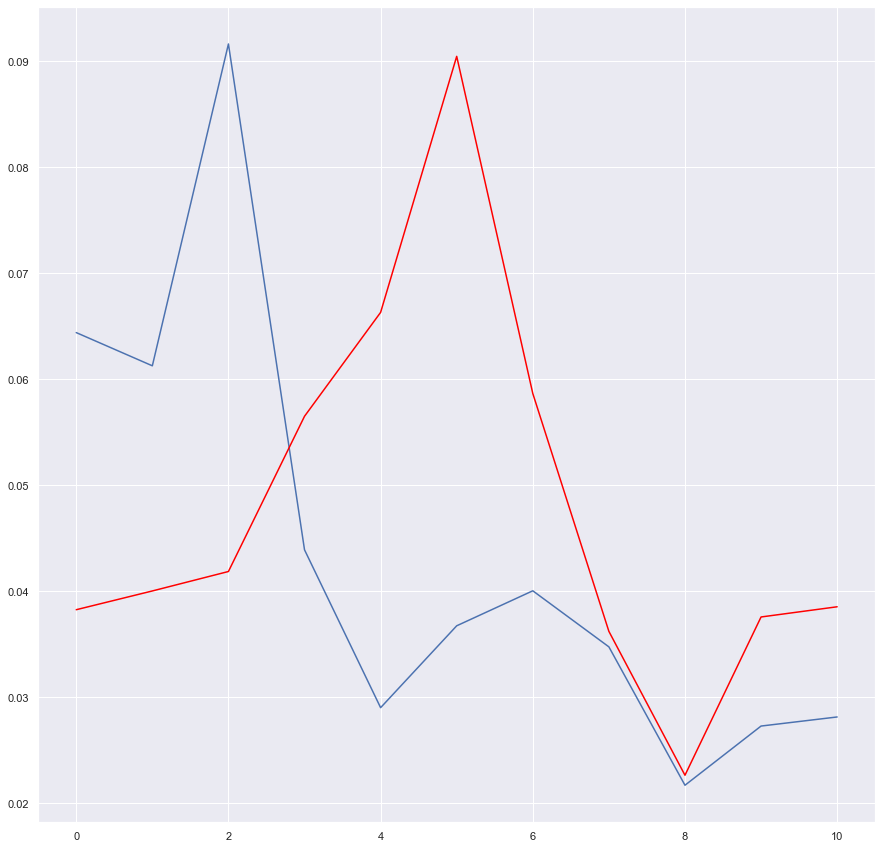

In [88]:
plotComparison(time_seq['AI'], subject_predictions_list['AI'])

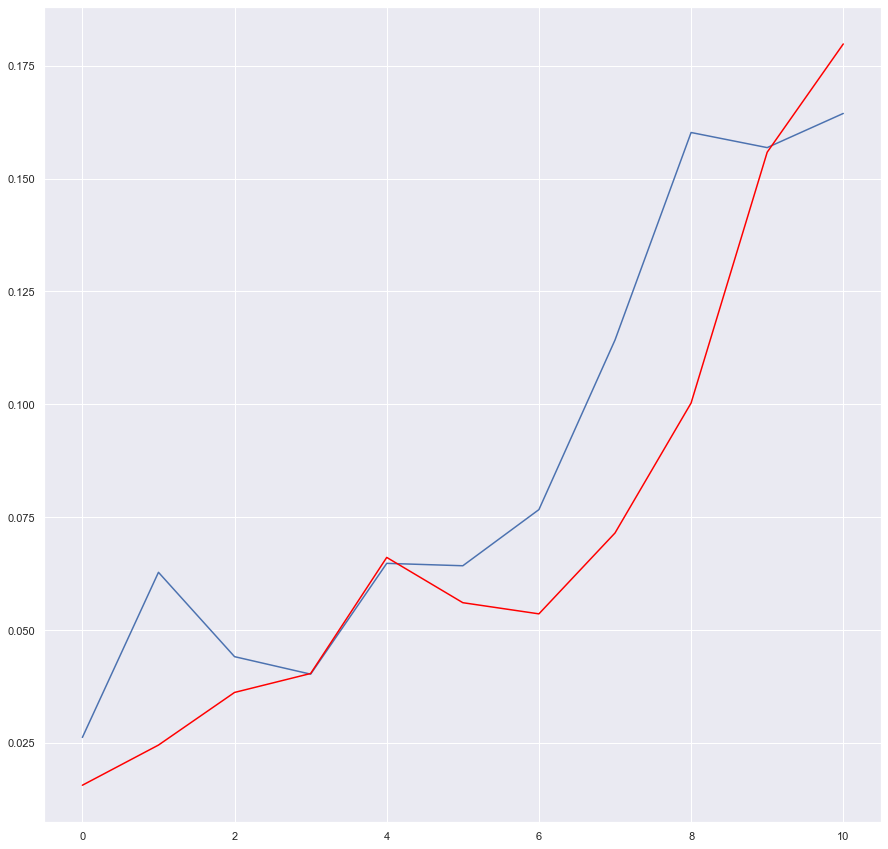

In [89]:
plotComparison(time_seq['LG'], subject_predictions_list['LG'])

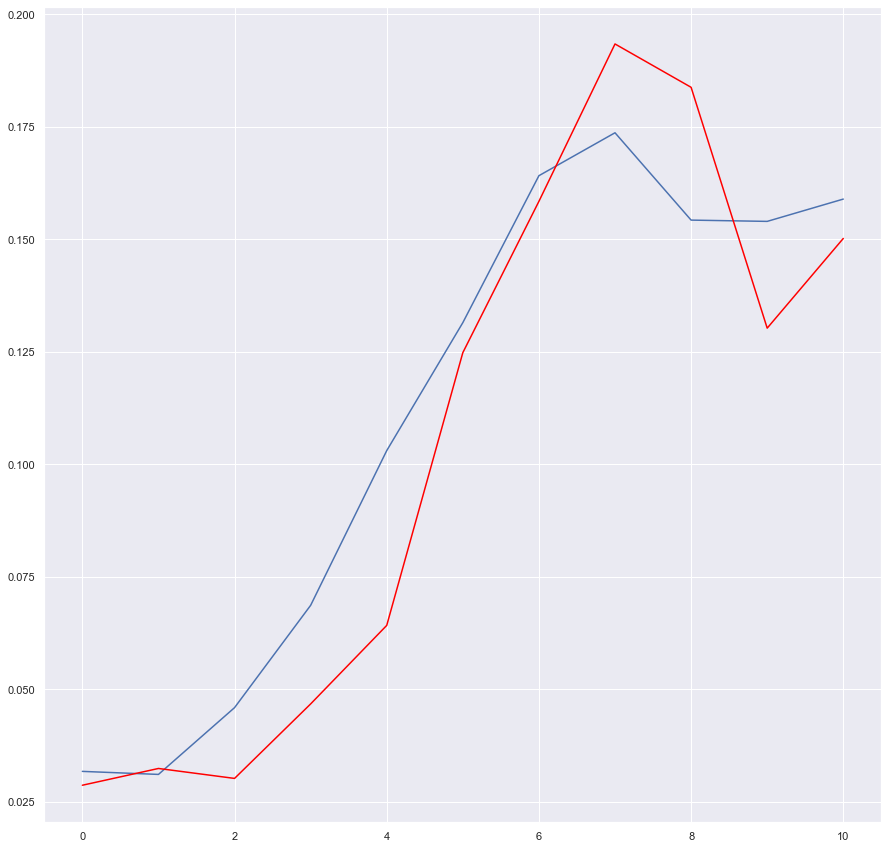

In [90]:
plotComparison(time_seq['CV'], subject_predictions_list['CV'])

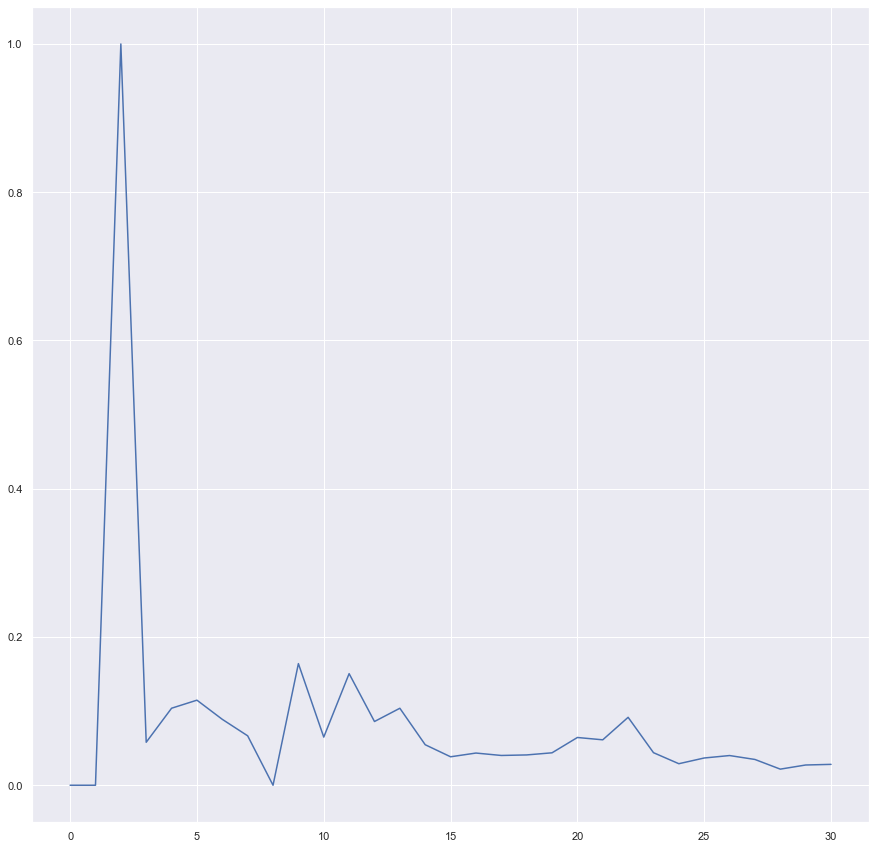

In [91]:
pyplot.plot(time_seq['AI'])

Linguistic predictions

In [92]:
#Subject change = SUM(normalized topic share * topic change)
# subject topics : {'IT': {150: 0.0434, 165:0.02, ...}}
# predictions_list : how topic changed in time, array of arrays
def calcSubjectChange(subject_topics, predictions_list):
    subject_series = {}
    for subj in subject_topics.keys():
        subject_series[subj] = np.zeros(len(predictions_list[0]))
        for topic in subject_topics[subj].keys():
            subject_series[subj] = np.add(subject_series[subj], subject_topics[subj][topic]*predictions_list[int(topic)])

    return subject_series

In [93]:
df_combined

,abstract,list_categories,main_categories,year,doubleFilteredAbstracts,topic_hits,topics,subfield
0,This paper studies the impact of a transmitt...,"[cs.IT, math.IT]","[cs, math]",2018,"[paper-studies, impact, transmitter, molecule,...","{13: 1, 196: 1, 99: 1, 48: 4, 102: 3, 19: 1, 1...","(13, 196, 99, 48, 102, 19, 184, 23, 139, 176, ...",IT
1,Deep Reinforcement Learning (DRL) is conside...,"[cs.LG, cs.AI]",[cs],2021,"[deep-reinforcement-learning, drl, framework, ...","{132: 3, 23: 1, 58: 1, 9: 1, 119: 1, 152: 1, 8...","(132, 23, 58, 9, 119, 152, 81, 154, 197, 151, ...",LG
2,Ad and tracking blocking extensions are popu...,[cs.CR],[cs],2018,"[tracking, blocking, popular, tools, improving...","{129: 2, 59: 3, 142: 1, 102: 1, 58: 1, 60: 1, ...","(129, 59, 142, 102, 58, 60, 6, 25, 136, 105, 4...",CR
3,"We introduce a simple, geometric model of op...","[cs.SI, econ.TH]","[cs, econ]",2019,"[model, opinion, polarization, model, politica...","{152: 1, 188: 1, 57: 1, 60: 1, 121: 1, 91: 1, ...","(152, 188, 57, 60, 121, 91, 140, 196, 170, 25,...",SI
4,Computer vision (CV) has achieved great succ...,[cs.CV],[cs],2020,"[computer-vision, achieved-great, success, sem...","{197: 1, 14: 1, 70: 1, 162: 1, 142: 2, 81: 1, ...","(197, 14, 70, 162, 142, 81, 22, 82, 123, 91, 1...",CV
...,...,...,...,...,...,...,...,...
99995,The number partitioning problem is the probl...,"[cs.DS, cs.IT, math.CO, math.IT]","[cs, math]",2020,"[number, partitioning, problem-problem, partit...","{91: 1, 8: 2, 101: 1, 144: 1, 88: 2, 152: 1, 5...","(91, 8, 101, 144, 88, 152, 50, 23, 10, 54, 27,...",DS
99996,"As life expectancy is mostly increasing, the...",[cs.GR],[cs],2020,"[life, disorders, constantly, growing, improvi...","{120: 1, 55: 1, 73: 1, 138: 1, 58: 1, 196: 1, ...","(120, 55, 73, 138, 58, 196, 97, 4, 40, 6, 102,...",GR
99997,We study descriptive complexity properties o...,[cs.FL],[cs],2017,"[study, descriptive, complexity, properties, l...","{140: 1, 10: 1, 84: 1, 88: 1, 104: 7, 36: 1, 9...","(140, 10, 84, 88, 104, 36, 94, 125, 174, 38, 4...",FL
99998,"We introduce a binary, relaxed gradient, tru...","[quant-ph, cs.NA, math.DS, math.NA, math.OC]","[quant-ph, cs, math]",2021,"[introduce, binary, optimizing, pulse, sequenc...","{23: 1, 96: 2, 176: 1, 130: 1, 36: 1, 114: 1, ...","(23, 96, 176, 130, 36, 114, 18, 88, 102, 2, 91...",NaN


In [94]:
subject_series_topics = calcSubjectChange(subject_topics, predictions_list)
subject_series_topic_hits = calcSubjectChange(subject_topic_hits, predictions_list)

In [95]:
clusters

{141: ['network',
  'networks',
  'nodes',
  'node',
  'routing',
  'consensus',
  'links',
  'connectivity',
  'network-structure',
  'complex-networks',
  'neighbors',
  'community-detection',
  'network-topology',
  'connections',
  'routes',
  'nodes-network',
  'forwarding',
  'network-nodes',
  'degree-distribution',
  'community-structure',
  'neighborhood'],
 58: ['performance',
  'improve',
  'accuracy',
  'quality',
  'achieve',
  'better',
  'achieves',
  'robustness',
  'achieving',
  'improving',
  'achieved',
  'scalability',
  'improvement',
  'improves',
  'improvements',
  'maintaining',
  'reliability',
  'improved',
  'performances',
  'faster',
  'efficiency',
  'overall',
  'good',
  'compared',
  'speed',
  'greatly',
  'lower',
  'higher',
  'increased'],
 156: ['learning',
  'training',
  'classification',
  'labels',
  'unsupervised',
  'label',
  'supervised',
  'supervision',
  'transfer-learning',
  'supervised-learning',
  'representation-learning',
  'data

In [98]:
sorted_chi_values_quicker

{'network': 9161.33824552566,
 'performance': 7891.2878478353105,
 'learning': 7782.914369494688,
 'task': 7456.553571106779,
 'algorithm': 7343.140311926993,
 'algorithms': 7249.992553207945,
 'training': 6738.52199678461,
 'tasks': 6403.861227383225,
 'dataset': 6150.3461362475055,
 'information': 5940.615366161214,
 'networks': 5590.72010086814,
 'problem': 5250.097340559977,
 'users': 5163.349366006986,
 'mass': 5144.493035163703,
 'datasets': 5016.326592557829,
 'design': 4891.600373058842,
 'user': 4816.728089212862,
 'learn': 4679.176349782712,
 'methods': 4278.668864275101,
 'architecture': 4029.627885940958,
 'human': 3936.6078805747425,
 'observed': 3895.6070947547,
 'propose': 3839.138744795536,
 'research': 3765.0958520309778,
 'trained': 3704.0681999312774,
 'problems': 3652.175974779978,
 'based': 3582.061921536679,
 'multiple': 3538.4276721891265,
 'spin': 3531.3082246821555,
 'temperature': 3475.6540720544244,
 'approach': 3356.5430730205644,
 'emission': 3334.247137371

In [99]:
subject_topics['AI'][199]

0.0026495162708883024

In [100]:
len(subject_topics['AI'])

200

In [ ]:
#Predictions
subject_predictions_topics = {}
subject_predictions_topic_hits = {}

for subj in subject_series_topics.keys():
    subject_predictions_topics[subj] = arima_func(subject_series_topics[subj])
for subj in subject_series_topic_hits.keys():
    subject_predictions_topic_hits[subj] = arima_func(subject_series_topic_hits[subj])

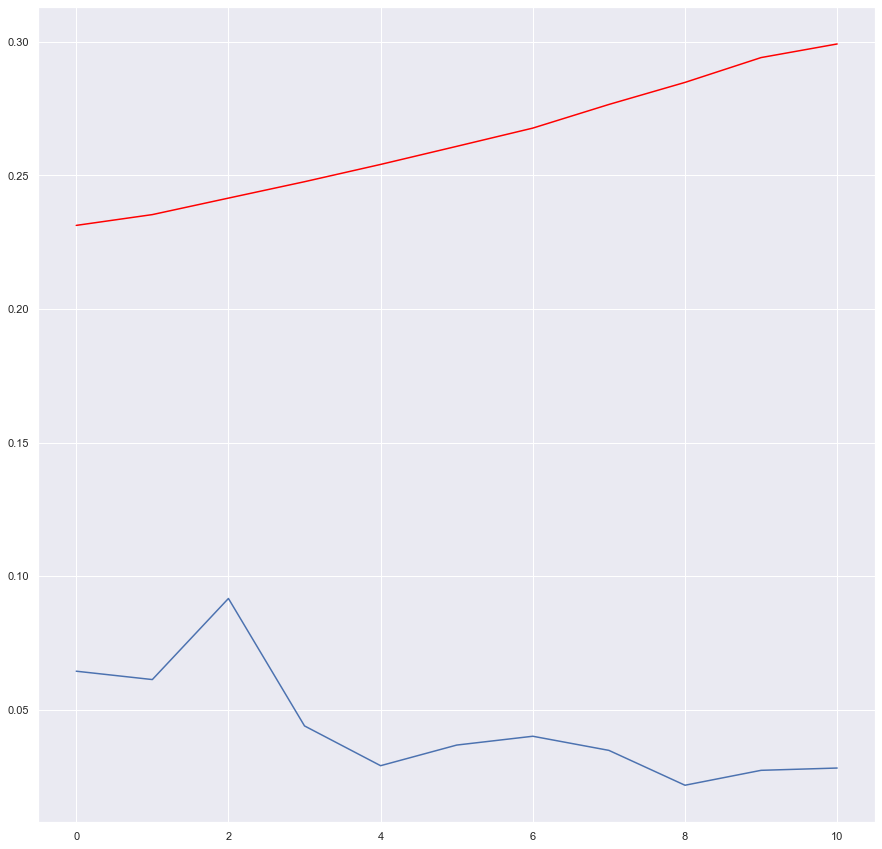

In [103]:
plotComparison(time_seq['AI'], subject_series_topics['AI'])

Finding the most distinctive topics for each subfield using chi-squared

In [ ]:
topics_no

In [207]:
all = sorted(list(topics_no['IT'].keys()))
all_diff = []
for topic in topics_no.keys():
    keys = list(topics_no[topic].keys())
    diff = [x for x in all if x not in keys]
    all_diff.extend(diff)
all_diff = list(set(all_diff))
print(all_diff)
print(len(all_diff))

[0, 5, 8, 11, 12, 15, 16, 17, 20, 21, 26, 29, 32, 35, 37, 40, 41, 42, 43, 47, 50, 51, 52, 53, 55, 56, 57, 62, 63, 64, 67, 69, 70, 71, 75, 77, 79, 80, 82, 86, 87, 92, 93, 94, 95, 98, 99, 101, 107, 108, 110, 112, 115, 116, 117, 118, 122, 124, 126, 127, 130, 131, 132, 134, 135, 137, 145, 147, 148, 149, 150, 155, 156, 159, 160, 161, 163, 164, 166, 167, 172, 176, 177, 178, 182, 183, 184, 185, 186, 187, 192, 193, 194, 195, 198, 199]
96


In [ ]:
# a - number of times t and c co-occur 11 (term occurs in cs)
# b - number of times t occurs w/o c 10 (term occurs in random)
# c - number of times c occurs w/o t 01 (cs which dont contain term)
# d - number of times neither c nor t occur 00 (random which dont contain term)
def findChiValuesForTopics(subject_topics):
    occurance_dict = {}
    chi_values = {}
    for instance in cs_dict['filteredAbstracts'].keys():
        terms = Counter(cs_dict['filteredAbstracts'][instance])
        for term in terms.keys():
            if(term in occurance_dict.keys()):
                if('a' in occurance_dict[term].keys()):
                    occurance_dict[term]['a'] += 1
                else:
                    occurance_dict[term]['a'] = 1
            else:   
                occurance_dict[term] = {'a' : 1}
    for instance in random_dict['filteredAbstracts'].keys():
        terms = Counter(random_dict['filteredAbstracts'][instance])
        for term in terms.keys():
            if(term in occurance_dict.keys()):
                if('b' in occurance_dict[term].keys()):
                    occurance_dict[term]['b'] += 1
                else:
                    occurance_dict[term]['b'] = 1
            else:
                occurance_dict[term] = {'b' : 1}
    for term in occurance_dict.keys():
        if('a' in occurance_dict[term].keys()):
            occurance_dict[term]['c'] = int(n/2)-occurance_dict[term]['a']
        else:
            occurance_dict[term]['c'] = int(n/2)
            occurance_dict[term]['a'] = 0
        if('b' in occurance_dict[term].keys()):
            occurance_dict[term]['d'] = int(n/2)-occurance_dict[term]['b']
        else:
            occurance_dict[term]['d'] = int(n/2)
            occurance_dict[term]['b'] = 0
        chi_values[term] = chi_square(n, occurance_dict[term]['a'], occurance_dict[term]['b'], occurance_dict[term]['c'], occurance_dict[term]['d'])
    return chi_values

Linguistic approach attempt 2

Here, I will determine the % of change for each topic that is contained in a subject. Then, for the prediction sequence, I will iterpolate the next year as the normalized subject in this year * (sum of % change of topic * normalized share of topic)

% change of topic is absolute

In [96]:
hits_normalized.keys()

dict_keys([2021, 2020, 2019, 2018, 2017, 2016, 2015, 2014, 2013, 2012, 2011, 2010, 2009, 2008, 2007, 2006, 2005, 2004, 2003, 2002, 2001, 2000, 1999, 1998, 1997, 1996, 1995, 1994, 1993, 1991])

In [97]:
def findTopicChange(hits_normalized):
    topic_change_y2y = {}
    for year in hits_normalized.keys():
        topic_change_y2y[year] = {}
        for topic in hits_normalized[year].keys():
            if(year == 1991):
                topic_change_y2y[year][topic] = 0
            elif(year == 1993):
                if(topic in hits_normalized[year-2].keys()):
                    topic_change_y2y[year][topic] = (hits_normalized[year][topic]-hits_normalized[year-2][topic])/hits_normalized[year-2][topic]
                else:
                    topic_change_y2y[year][topic] = 0
            elif(topic in hits_normalized[year-1].keys()):
                topic_change_y2y[year][topic] = (hits_normalized[year][topic]-hits_normalized[year-1][topic])/hits_normalized[year-1][topic]
            else:
                topic_change_y2y[year][topic] = 0
    return topic_change_y2y

In [121]:
def findTopicChangeOnSeries(series):
    topic_change = np.zeros(len(series))
    topic_change[0] = 0
    for year in range(1,len(series)):
        if(series[year] > 0):
            topic_change[year] = (series[year]-series[year-1])/series[year]
        elif(series[year-1]>0):
            topic_change[year] = 1
        else:
            topic_change[year] = 0
    return topic_change

In [98]:
topic_change_y2y = findTopicChange(hits_normalized)
topic_change_y2y

{2021: {152: 0.021134189768004644,
  142: 0.01050672580602132,
  140: 0.0022790612434185347,
  23: 0.013796287138363934,
  169: 0.005393868454162367,
  81: 0.032667026184887836,
  196: 0.005414257060567566,
  91: -0.012575181809401422,
  58: 0.022544638015701446,
  102: 0.01750652741062558,
  97: 0.012806423549848263,
  111: 0.0113988551395363,
  36: -4.8995130372439516e-05,
  128: 0.010298798371299172,
  25: 0.005849868892331699,
  14: 0.04757328582287626,
  78: 0.05216188973994619,
  88: -0.02884434920598831,
  2: 0.025187061737391228,
  136: 0.04535140407471038,
  156: 0.019577296769086608,
  123: 0.04305376730478477,
  176: -0.0010687562289702585,
  68: 0.014268649303725813,
  18: -0.002282957693140037,
  31: 0.016691089173804834,
  174: -0.047176742405272344,
  90: -0.016741781780614473,
  54: -0.03672235156619581,
  72: -0.0054060587091779135,
  141: -0.03077341702259999,
  197: 0.03737764130828735,
  162: 0.0025818445112208563,
  168: 0.001619465401006373,
  166: 0.0135543798361

In [99]:
# Arima 
#ARIMA function
def arima_func_2(series, y2y, time_period):
    #Forcasting
    X = series
    size = int(len(X) - time_period)
    train, test = X[0:size], X[size:len(X)]
    history = [x for x in train]
    predictions = list()
    # walk-forward validation
    for t in range(len(test)):
        model = ARIMA(history, order=(5,1,0))
        model_fit = model.fit()
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test[t]
        if(y2y):
            history.append(obs)
        else:
            history.append(yhat)
    # evaluate forecasts
    #rmse = sqrt(mean_squared_error(test, predictions))
    
    return predictions

In [135]:
# Forming the predicting time sequence
def predict(y_p, time_seq, subject_topics, y2y, time_period):
    #Form an arima seqence for the topics
    topic_predictions = np.zeros((len(y_p),time_period))
    for topic in range(len(y_p)):
        topic_predictions[topic] = arima_func_2(y_p[topic], y2y, time_period)

    total_years = len(y_p[0])

    #form topic change on topic_predictions
    topic_changes = np.zeros((len(y_p),total_years))
    for topic in range(len(y_p)):
        topic_changes[topic] = findTopicChangeOnSeries(y_p[topic])


    #Form subject predictions
    subject_seq = {}
    for subject in subject_topics.keys():
        subject_seq[subject] = np.zeros(time_period)
        subject_seq[subject][0] = time_seq[subject][total_years-time_period]
        for i in range(1,time_period):
            for topic in subject_topics[subject].keys():
                subject_seq[subject][i] += topic_changes[topic][total_years-time_period+i]*subject_topics[subject][topic]
            print(subject, subject_seq[subject])
            if(y2y):
                subject_seq[subject][i] = (subject_seq[subject][i]+1)*subject_seq[subject][i-1]
            else:
                subject_seq[subject][i] = (subject_seq[subject][i]+1)*time_seq[subject][total_years-time_period+i-1]

    return subject_seq

In [136]:
subject_seq = predict(y_p, time_seq, subject_topics, True, 10)

/Users/miamijovic/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/miamijovic/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/miamijovic/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/miamijovic/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/miamijovic/opt/anaconda3/

IT [ 0.13063764 -0.00722721  0.          0.          0.          0.
  0.          0.          0.          0.        ]
IT [0.13063764 0.12969349 0.04184741 0.         0.         0.
 0.         0.         0.         0.        ]
IT [0.13063764 0.12969349 0.13512083 0.01867349 0.         0.
 0.         0.         0.         0.        ]
IT [0.13063764 0.12969349 0.13512083 0.137644   0.00166466 0.
 0.         0.         0.         0.        ]
IT [ 0.13063764  0.12969349  0.13512083  0.137644    0.13787313 -0.0049099
  0.          0.          0.          0.        ]
IT [ 0.13063764  0.12969349  0.13512083  0.137644    0.13787313  0.13719619
 -0.01776799  0.          0.          0.        ]
IT [ 0.13063764  0.12969349  0.13512083  0.137644    0.13787313  0.13719619
  0.13475849 -0.00240677  0.          0.        ]
IT [0.13063764 0.12969349 0.13512083 0.137644   0.13787313 0.13719619
 0.13475849 0.13443415 0.00317789 0.        ]
IT [0.13063764 0.12969349 0.13512083 0.137644   0.13787313 0.1371

/Users/miamijovic/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


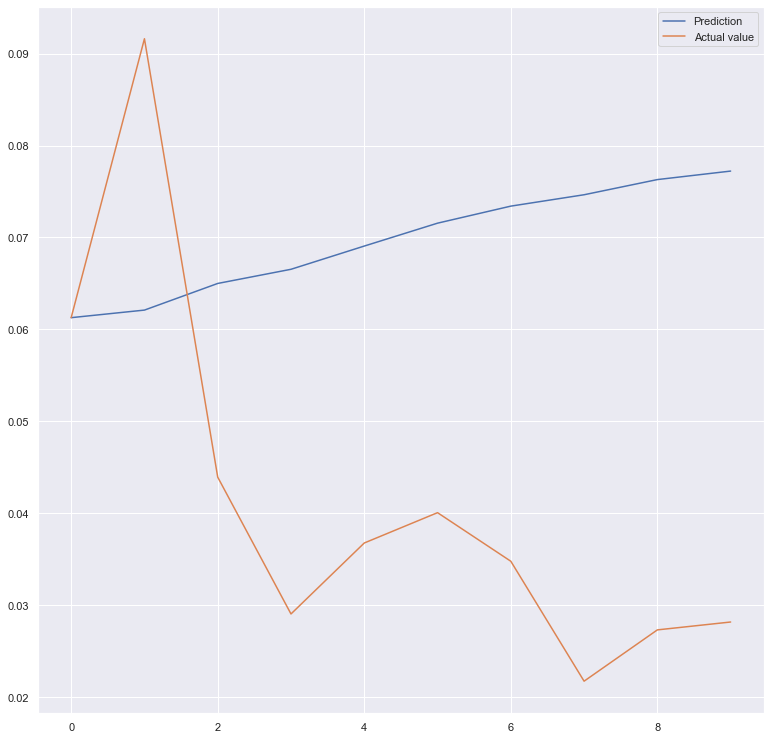

In [159]:
pyplot.plot(subject_seq['AI'][0:], label = 'Prediction')
pyplot.plot(time_seq['AI'][21:], label='Actual value')
pyplot.legend()
pyplot.savefig('AIcomparison.png')